# SWE pre-processing
This Notebook reads SWE observations (CanSWE, 1928-2020, available from Zenodo [here](https://zenodo.org/record/5217044#.YXnF0S1b1mA)) and precipitation observations (SCDNA, 1979-2018 (Version 1.1), also available from Zenodo [here](https://zenodo.org/record/3953310#.YXnGQS1b1mA)) for a test river basin. From these data, it fills the gaps in SWE observations using quantile mapping, and performs a principal component analysis to obtain principal components of SWE for the first day of each month of each year when data is available.

To produce a DEM for your region of interest (e.g., see the DEM_testbasin under the user-defined paths below), follow the instructions [here](https://github.com/CH-Earth/summaWorkflow_public/blob/master/3b_parameters/MERIT_Hydro_DEM/4_specify_subdomain/specify_subdomain.sh) and [here](https://github.com/CH-Earth/summaWorkflow_public/blob/master/3b_parameters/MERIT_Hydro_DEM/5_convert_to_tif/convert_vrt_to_tif.sh). A readme.txt file is otherwise available on Copernicus at: /globalhome/lla068/HPC/dem_generation/

Decisions:
- At the moment we are not applying any buffer around the basin (but parts of the workflow are able to read external/buffer stations). This means that only SWE and P stations within the test basin are used. See user-specified variables below. We could make distance-decay plots to look at the stations' correlation vs distance to choose an optimal buffer distance for each basin. 
- The water year definition: October 1st to September 30th. See user-specified variables below. Note: We assume that the snow season overlaps two subsequent calendar years for calculations below (e.g., the cumulative precipitation).
- We do not look at data stationarity.
- For each target station and each date for which date is missing, we identify a donor stations as the station with: 
    - data for this date, 
    - a cdf for this doy,
    - and the best correlation to the target station (correlation >= 0.6 for this doy).
- The minimum correlation allowed to select an optimal donor station is set to 0.6 at the moment (no negative correlations selected). See user-specified variables below.
- The minimum number of overlapping observations required to calculate the correlation between 2 stations is set to  3 at the moment. See user-specified variables below.
- The minimum number of observations required to calculate a station's cdf is set to 10 at the moment. See user-specified variables below.
- We use a time window of +/- 7 days on either side of the infilling date for gap filling calculations. See user-specified variables below.
- The minimum number of observations required to calculate the KGE'' is set to 3 at the moment. See user-specified variables below.
- The number of times we repeat the artificial gap filling to assess its quality is set to 10 at the moment. See user-specified variables below.
- We evaluate the artificial gap filling quality based on the RMSE and KGE'' decomposition.
- As a result of the PCA design, we assume that we will use all PCs monthly data independently from others months for the forecasting. This is to ensure that we maximize the amount of data we can use each month (e.g., 1st April has more data than 1st November and we would have to drop all the additional data in April if we were to unify the PCA across months).
- We use SWE data for the 1st of each month only for the forecasting.

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [1]:
# Import required modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
from datetime import timedelta
from shapely.geometry import Point
import warnings
import math
import random
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import rasterio
from rasterio.plot import show
import matplotlib.patches as mpatches

In [2]:
# Set required data paths
SWE_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/snow_obs_Canada/ECCC_CanSWE-CanEEN_1928-2020_v1_DONOTSHAREWITHANYONE.nc"  # SWE observations NetCDF - note that this version of the data contains sensitive Quebec SWE data, and was provided by Vincent Vionnet (ECCC) to Louise Arnal (USask) under after Louise received written permission from HydroQuebec & MELCC. The openly available version of this dataset (without sensitive Quebec data) can be downloaded directly from Zenodo (see link above) 
met_obs_path = "/Users/lla068/Documents/data_driven_forecasting/data/SCDNA_v1.1.nc4" # SCDNA meteorological observations NetCDF
shp_path = "/Users/lla068/Documents/data_driven_forecasting/basins/"  # basin shapefiles directory
DEM_testbasin = '/Users/lla068/Documents/data_driven_forecasting/basins/bow_MERIT_DEM.tif' # test basin DEM tif file

In [3]:
# Set user-specified variables
testbasin_id = '05BB001'  # test basin ID taken from WSC HYDAT
testbasin_name = 'Bow River at Banff'  # test basin name taken from WSC HYDAT
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_overlap_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
iterations_default = 10 # the number of times we repeat the artificial gap filling
artificial_gap_perc_default = 50 # the percentage of observations to remove during the artificial gap filling for each station & month's first day

In [4]:
def stations_basin_map(basin, stations, flag, buffer_km=0):
    
    """Plots map of SWE stations and basin shape.
    
    Keyword arguments:
    ------------------
    - basin: Pandas GeoDataFrame of basin to plot
    - stations: Pandas GeoDataFrame of SWE stations to plot
    - flag: Flag to indicate if no buffer (0) or a buffer (1) should be plotted around the basin
    - buffer_km: Positive value (in km) of buffer to add around basin shapefile (default=0; i.e., no buffer)
    
    Returns:
    --------
    - A map of SWE stations and basin shape.
    
    """
    
    # Initialize the figure
    fig, ax = plt.subplots()
    
    # If there is no buffer
    if flag == 0:
        # calculating map bounds
        minx, miny, maxx, maxy = basin.geometry.total_bounds
    
    # If there is a buffer
    if flag == 1:
        
        # convert basin geometry to a different epsg to be able to add a buffer in meters
        basin_crs_conversion = basin.to_crs(epsg=3763)
        
        # add a buffer in meters
        buffer_m = buffer_km * 1000
        basin_buffer = basin_crs_conversion.buffer(buffer_m)
        
        # convert the buffer back to meters for plotting
        basin_buffer = basin_buffer.to_crs(epsg=4326)
        
        # calculate map bounds
        minx, miny, maxx, maxy = basin_buffer.geometry.total_bounds
        
        # plot the basin buffer
        basin_buffer.plot(ax=ax, alpha=.5)
    
    # Plot the basin and SWE stations
    basin.plot(ax=ax, alpha=.8)
    stations.plot(ax=ax, marker='o', color='b', markersize=10)
    
    ax.set_xlim(minx - .1, maxx + .1)
    ax.set_ylim(miny - .1, maxy + .1);

In [5]:
def extract_stations_in_basin(stations, basins, basin_id, buffer_km=0):
    
    """Extracts stations within a specified basin (with or without a buffer) and returns the extracted stations.
    
    Keyword arguments:
    ------------------
    - stations: Pandas GeoDataFrame of all stations available to subset from
    - basins: Pandas GeoDataFrame of all basin shapefiles available to subset from
    - basin_id: String of basin station ID
    - buffer_km: Positive value (in km) of buffer to add around basin shapefile (default=0; i.e., no buffer)
    
    Returns:
    --------
    - stations_in_basin: Pandas GeoDataFrame of all stations within the specified basin
    - basin_buffer: Zero if the default buffer is selected, otherwise buffer geometry for plotting
    
    """
    
    # Extract SWE stations within basin only (i.e., no buffer)
    if buffer_km == 0:
        basin_buffer = 0        
        mask = stations.within(basins.loc[basins['Station'] == basin_id].iloc[0].loc["geometry"])

    # Extract SWE stations within specified buffer of basin
    elif buffer_km > 0:
        
        # convert basin & stations geometry to a different CRS to be able to add a buffer in meters
        basin_crs_conversion = basins.loc[basins['Station'] == basin_id].to_crs(epsg=3763)
        stations_crs_conversion = stations.to_crs(epsg=3763)
        
        # add a buffer in meters around the basin
        buffer_m = buffer_km * 1000
        basin_buffer = basin_crs_conversion.buffer(buffer_m)
        mask = stations_crs_conversion.within(basin_buffer.iloc[0])
        
        # convert the buffer back to the original CRS for plotting
        basin_buffer = basin_buffer.to_crs(epsg=4326)

    stations_in_basin = stations.loc[mask].assign(basin=basin_id)
    
    return stations_in_basin, basin_buffer

In [96]:
def data_availability_monthly_plots(SWE_stations, original_SWE_data, gapfilled_SWE_data, flag):
    
    """Calculating and plotting the % of SWE stations available on the first day of each month of each year.
    
    Keyword arguments:
    ------------------
    - SWE_stations: Pandas GeoDataFrame of all SWE stations
    - original_SWE_data: xarray DataArray of the original SWE observations
    - gapfilled_SWE_data: xarray DataArray of the SWE observations after gap filling
    - flag: Flag to indicate if gap filled data was provided (1) or not (0). In the case that it is provided, a comparison plot will be made to compare data availability in the original data vs the gap filled data
    
    Returns:
    --------
    - Bar chart timeseries of SWE stations available on the first day of each month of each year
    
    """
    
    # Initialize plot
    fig, axs = plt.subplots(6, 2, sharex=True, sharey=True, figsize=(14,8))
    elem = -1
    column = 0
    
    # Loop over months
    for m in range(1,12+1):
        
        # controls for plotting on right subplot (i.e., month)
        elem += 1
        if elem == 6:
            column += 1
            elem = 0
        
        # for SWE data with gap filling
        if flag == 1:
            
            # extract data on the first of the month m
            data_month_gapfilled = gapfilled_SWE_data.sel(station_id=SWE_stations.station_id.values, time=( (gapfilled_SWE_data['time.month'] == m) & (gapfilled_SWE_data['time.day'] == 1) ))
            
            # count the % of stations with data on those dates
            data_month_gapfilled_count = data_month_gapfilled.count(dim='station_id') / len(SWE_stations) * 100
            
            # plot bar chart of available data
            axs[elem,column].bar(data_month_gapfilled_count['time.year'], data_month_gapfilled_count.data, color='r', alpha=.5)
        
        # same process as above but for original SWE data
        data_month = original_SWE_data.sel(station_id=SWE_stations.station_id.values, time=( (original_SWE_data['time.month'] == m) & (original_SWE_data['time.day'] == 1) ))
        data_month_count = data_month.count(dim='station_id') / len(SWE_stations) * 100
        axs[elem,column].bar(data_month_count['time.year'], data_month_count.data, color='b')
        
        # add plot labels
        if elem == 5 and column == 0:
            axs[elem,column].set_ylabel('% available stations')
        axs[elem,column].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(1), fontweight='bold')
        
        if flag == 1:
            bluepatch = mpatches.Patch(color='b', label='original data')
            redpatch = mpatches.Patch(color='r', alpha=.5, label='after gap filling')
            plt.legend(handles=[bluepatch, redpatch])
    
    plt.tight_layout();

In [7]:
def calculate_stations_doy_corr(stations_obs, window_days, min_obs_overlap):
    
    """Calculating stations' correlations for each day of the year (doy; with a X-day window centered around the doy).
    
    Keyword arguments:
    ------------------
    - stations_obs: Pandas DataFrame of all SWE & P stations observations
    - window_days: Positive integer denoting the number of days to select data for around a certain doy, to calculate correlations
    - min_obs_overlap: Positive integer for the minimum number of overlapping observations required to calculate the correlation between 2 stations

    Returns:
    --------
    - stations_doy_corr: Dictionary containing a Pandas DataFrame of stations correlations for each day of year
    
    """

    # Set up the dictionary to save all correlations
    stations_doy_corr = {}

    # Duplicate the stations observations Pandas DataFrame and add doy column
    stations_obs_doy = stations_obs.copy()
    stations_obs_doy['doy'] = stations_obs_doy.index.dayofyear

    # Loop over days of the year
    for doy in range(1,365+1):

        # calculate the start & end of the data selection window, with caution around the start & end of the calendar year
        window_start = (doy-window_days)%366 
        if window_start == 0:
            window_start = 365
        window_end = (doy+window_days)%366
        if window_end == 0 or window_end == 365:
            window_end = 366
            
        # select data for the window of interest
        if window_start > window_end:
            data_window = stations_obs_doy[(stations_obs_doy['doy']>=window_start) | (stations_obs_doy['doy'] <= window_end)]
        else:
            data_window = stations_obs_doy[(stations_obs_doy['doy']>=window_start) & (stations_obs_doy['doy'] <= window_end)]
            
        # calculate the Pearson product-moment correlations between stations if the minimum number of observations criterium is met
        data_window = data_window.drop(columns=['doy'])
        corr = data_window.corr(method='pearson', min_periods=min_obs_overlap)
        np.fill_diagonal(corr.values, np.nan)
        
        # save correlation for the doy to the dictionary
        stations_doy_corr[doy] = corr
            
    return stations_doy_corr

In [8]:
def quantile_mapping(data_donor, data_target, value_donor, min_obs_cdf, flag):
    
    """Calculating target station's gap filling value from donor station's value using quantile mapping.
    
    Keyword arguments:
    ------------------
    - data_donor: Pandas DataFrame of donor station observations used to build empirical cdf
    - data_target: Pandas DataFrame of target station observations used to build empirical cdf
    - value_donor: Integer of donor station value used in the quantile mapping
    - min_obs_cdf: Positive integer for the minimum number of stations required to calculate a station's cdf
    - flag: Integer to plot (1) or not (0) the donor and target stations' cdfs

    Returns:
    --------
    - value_target: Integer of target station value calculated using quantile mapping
    - plot of the donor and target stations' cdfs (optional)
    
    """
    
    # Calculate the donor & target stations' cdfs if they both have at least X observations
    if (len(data_donor) >= min_obs_cdf) & (len(data_target) >= min_obs_cdf):
    
        # build the donor station's empirical cdf and calculate the cumulative probability corresponding to the donor value
        sorted_data_donor = data_donor.drop_duplicates().sort_values(ignore_index=True)
        rank_donor_obs = sorted_data_donor[sorted_data_donor == value_donor].index[0]
        total_obs_donor = len(sorted_data_donor)
        cumul_prob_donor_obs = (rank_donor_obs + 1) / total_obs_donor
        
        # build the target station's empiral cdf
        sorted_data_target = data_target.drop_duplicates().sort_values(ignore_index=True)
        cumul_prob_target = np.arange(1,len(sorted_data_target)+1) / (len(sorted_data_target))
        
        # inter-/extrapolate linearly to get the target value corresponding to the donor station's cumulative probability
        inverted_edf = interp1d(cumul_prob_target, sorted_data_target, fill_value="extrapolate")
        value_target = round(float(inverted_edf(cumul_prob_donor_obs)),2)
        
        # set any potential negative values from interpolation/extrapolation to zero
        if(value_target) < 0:
            value_target = 0
        
        # if requested, plot the target & donor stations' cdfs
        if flag == 1:
            plt.figure()
            plt.plot(sorted_data_donor, np.arange(1,len(sorted_data_donor)+1) / (len(sorted_data_donor)), label='donor')
            plt.plot(sorted_data_target, cumul_prob_target, label='target')
            plt.scatter(value_donor, cumul_prob_donor_obs)
            plt.legend()
        
        return value_target
    
    # If either/both the target & donor stations have < X observations do nothing
    else:
        return None

In [9]:
# This is the actual gap filling
def qm_gap_filling(original_data, artificial_gaps_data, window_days, min_obs_overlap, min_obs_cdf, min_corr, flag):
    
    """Performing the gap filling for all missing observations (when possible) using quantile mapping. 
    For each target station and each date for which date is missing, we identify a donor stations as the station with: 
    - data for this date, 
    - a cdf for this doy,
    - and the best correlation to the target station (correlation >= 0.6 for this doy).
    
    Keyword arguments:
    ------------------
    - original_data: Pandas DataFrame of original stations' observations dataset, which will be gap filled
    - artificial_gaps_data: Pandas DataFrame of stations' observations dataset with artifical gaps which will be gap filled if flag=1
    - window_days: Positive integer denoting the number of days to select data for around a certain doy, to calculate correlations
    - min_obs_overlap: Positive integer for the minimum number of overlapping observations required to calculate the correlation between 2 stations
    - min_obs_cdf: Positive integer for the minimum number of stations required to calculate a station's cdf
    - min_corr: Value between 0 and 1 for the minimum correlation value required to keep a donor station
    - flag: Integer to perform gap filling for a dataset with artifical gaps and different from the original dataset (1) or not (0)

    Returns:
    --------
    - gapfilled_data: Pandas DataFrame of gap filled stations' observations
    - data_type_flags: Pandas DataFrame with information about the type of data (estimates or observations) in the gap filled dataset
    - donor_stationIDs: Pandas DataFrame with information about the donor station used to fill each of the gaps
    
    """
    
    # Create a duplicate of the dataset to gap fill in order to save infilling values without over-writing the original dataset
    if flag == 0:
        gapfilled_data = original_data.copy()
    elif flag == 1:
        gapfilled_data = artificial_gaps_data.copy()
        
    # Remove P & external SWE stations (buffer) from Pandas DataFrame as we don't do any gap filling for these
    cols = [c for c in original_data.columns if 'precip' not in c and 'ext' not in c]
    gapfilled_data = gapfilled_data[cols]
    
    # Set empty Pandas DataFrame to keep track of data type (estimates vs observations)
    data_type_flags = pd.DataFrame(data=np.zeros((len(gapfilled_data.index), len(gapfilled_data.columns))), index=gapfilled_data.index, columns=gapfilled_data.columns)

    # Set empty Pandas DataFrame to keep track of donor station ids
    donor_stationIDs = pd.DataFrame(data=np.ones((len(gapfilled_data.index), len(gapfilled_data.columns)))*np.nan, index=gapfilled_data.index, columns=gapfilled_data.columns)
    
    # Calculate correlations between stations
    corr = calculate_stations_doy_corr(original_data, window_days, min_obs_overlap)
    
    # Identify dates for gap filling
    if flag == 0:
        time_index = original_data.index
    elif flag == 1:
        time_index = artificial_gaps_data.index
       
    # Loop over dates for gap filling
    for d in range(len(time_index)):
        
        # calculate the start and end dates of the time window for the gap filling steps
        window_startdate = time_index[d] - timedelta(days=window_days)
        window_enddate = time_index[d] + timedelta(days=window_days)

        # calculate the doy corresponding to the date - doy 365 and 366 are bundled together
        doy = int(time_index[d].strftime('%j'))
        if doy == 366:
            doy = 365
            
        # get ids of all stations with data for this date (+time window)
        data_window = original_data[window_startdate:window_enddate].dropna(axis=1, how='all')
        data_window['days_to_date'] = abs((time_index[d] - data_window.index).days)
        data_window = data_window.sort_values(by=['days_to_date'])
        donor_stations_data_window = {}
        for station in data_window.columns:
            if station != 'days_to_date':
                donor_stations_data_window[station] = data_window[station].dropna()[0]
        non_missing_stations = list(donor_stations_data_window.keys())

        # if there is at least one station with data on this date continue
        if len(non_missing_stations) > 0:
        
            # loop over stations
            for target_station in cols:
                
                # if station has no data, proceed with the gap filling
                if math.isnan(gapfilled_data[target_station].iloc[d]) == True:

                    # get ids of all stations with correlations >= a minimum correlation for this date
                    non_missing_corr = list(corr[doy][target_station].dropna()[corr[doy][target_station].dropna() >= min_corr].index.values)

                    # identify potential donor stations: stations with: data for this date, a cdf for this doy & correlation >= 0.6 for this doy
                    potential_donor_stations = set.intersection(set(non_missing_stations), set(non_missing_corr))
                    
                    # if there is at least one potential donor station, proceed
                    if len(list(potential_donor_stations)) > 0:

                        # sort potential donor stations from highest to lowest correlations to the target station
                        sorted_correlations = corr[doy].loc[potential_donor_stations,target_station].dropna().sort_values(ascending=False)
                        
                        # select the donor station with the best correlation
                        donor_station = sorted_correlations.index[0]

                        # create duplicate of data to add doy to the Pandas DataFrame
                        station_data_doy = original_data.copy()
                        
                        # remove the target station's value for the date to fill in case it was removed artificially
                        if flag == 1:
                            station_data_doy.loc[time_index[d],target_station] = artificial_gaps_data.loc[time_index[d],target_station]
                        
                        # add doy to the Pandas DataFrame
                        station_data_doy['doy'] = station_data_doy.index.dayofyear

                        # calculate the start & end doys of the time window for quantile mapping, with caution around the start & end of the calendar year
                        window_startdoy = (doy-window_days)%365 
                        if window_startdoy == 0:
                            window_startdoy = 365
                        window_enddoy = (doy+window_days)%365
                        if window_enddoy == 0 or window_enddoy == 365:
                            window_enddoy = 366

                        # select data within time window
                        if window_startdoy > window_enddoy:
                            data_window_donor = station_data_doy[donor_station].dropna()[(station_data_doy['doy']>=window_startdoy) | (station_data_doy['doy'] <= window_enddoy)]
                            data_window_target = station_data_doy[target_station].dropna()[(station_data_doy['doy']>=window_startdoy) | (station_data_doy['doy'] <= window_enddoy)]
                        else:
                            data_window_donor = station_data_doy[donor_station].dropna()[(station_data_doy['doy']>=window_startdoy) & (station_data_doy['doy'] <= window_enddoy)]
                            data_window_target = station_data_doy[target_station].dropna()[(station_data_doy['doy']>=window_startdoy) & (station_data_doy['doy'] <= window_enddoy)]
                            
                        # calculate target station's value from quantile mapping
                        value_target = quantile_mapping(data_window_donor, data_window_target, donor_stations_data_window[donor_station], min_obs_cdf, flag=0)
                        
                        # if a target value is found, proceed
                        if value_target != None:
                            
                            # gap filling with value from quantile mapping
                            gapfilled_data.loc[time_index[d],target_station] = value_target
                            
                            # set value flag as estimate
                            data_type_flags.loc[time_index[d],target_station] = 1
                            
                            # save the donor station's id
                            donor_stationIDs.loc[time_index[d],target_station] = donor_station

                        # else if no target value is found, skip to the next station
                        else:
                            continue
                    
                    # if there is no potential donor station for this target station & date, skip to the next station
                    else:
                        continue
                
                # else if station has data on this date, skip to the next station
                else:
                    continue
           
        # else if there is no station with data on this date, skip to next date
        else:
            continue   
                
    return gapfilled_data, data_type_flags, donor_stationIDs

In [10]:
def KGE_C2021(obs, pre, min_obs_KGE):
    
    """KGE'' proposed by Clark et al. (2021). See Equation 11: https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020WR029001
    This solves issues, where the KGE and KGE' may be problematic for zeros values.
    
    Keyword arguments:
    ------------------
    - obs: Numpy Array of observations to evaluate
    - pre: Numpy Array of predictions/simulations to evaluate
    - min_obs_KGE: Positive integer for the minimum number of stations required to calculate a station's cdf

    Returns:
    --------
    - KGEgroup: Dictionary containing the final KGE'' value as well as all elements of the KGE''
    
    """
    
    ind_nan = np.isnan(obs) | np.isnan(pre)
    obs = obs[~ind_nan]
    pre = pre[~ind_nan]
    
    if len(obs) > min_obs_KGE:
        pre_mean = np.mean(pre, axis=0, dtype=np.float64)
        obs_mean = np.mean(obs, axis=0, dtype=np.float64)
        r = np.sum((pre - pre_mean) * (obs - obs_mean), axis=0, dtype=np.float64) / \
            np.sqrt(np.sum((pre - pre_mean) ** 2, axis=0, dtype=np.float64) *
                    np.sum((obs - obs_mean) ** 2, dtype=np.float64))
        alpha = np.std(pre, axis=0) / np.std(obs, dtype=np.float64)
        beta = (np.mean(pre) - np.mean(obs)) / np.std(obs)
        KGE = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta) ** 2)
        KGEgroup = {'KGE': KGE, 'r': r, 'alpha': alpha, 'beta': beta}
    
    else:
        KGEgroup = {'KGE': np.nan, 'r': np.nan,
                    'alpha': np.nan, 'beta': np.nan}
    
    return KGEgroup

In [11]:
def artificial_gap_filling(original_data, iterations, artificial_gap_perc, window_days, min_obs_overlap, min_obs_cdf, min_corr, min_obs_KGE, flag):
    
    """Creating random artificial gaps in the original dataset for each month & station, and running the gap filling function to assess its performance.
    
    Keyword arguments:
    ------------------
    - original_data: Pandas DataFrame of original stations' observations dataset, to which data will be removed for artificial gap filling
    - iterations: Positive integer denoting the number of times we want to repeat the artificial gap filling (we remove data at random each time in the original dataset)
    - artificial_gap_perc: Percentage between 1 and 100 for the amount of data to remove for each station & month's first day 
    - window_days: Positive integer denoting the number of days to select data for around a certain doy, to calculate correlations
    - min_obs_overlap: Positive integer for the minimum number of overlapping observations required to calculate the correlation between 2 stations
    - min_obs_cdf: Positive integer for the minimum number of stations required to calculate a station's cdf
    - min_corr: Value between 0 and 1 for the minimum correlation value required to keep a donor station
    - min_obs_KGE: Positive integer for the minimum number of stations required to calculate a station's cdf
    - flag: Integer to plot the gap filled values vs the observed values (1) or not (0)

    Returns:
    --------
    - evaluation: Dictionary containing the artificial gap filling evaluation results for several metrics for each month's first day, station & iteration 
    
    """
    
    # Set up the figure
    if flag == 1:
        ncols = 3
        fig, axs = plt.subplots(4, ncols, sharex=False, sharey=False, figsize=(10,12))
        plot_col = -1
        row = 0

    # Identify stations for gap filling (without P & external SWE stations (buffer) as we don't do any gap filling for these)
    cols = [c for c in original_data.columns if 'precip' not in c and 'ext' not in c]
    
    # Create an empty dictionary to store the metric values for each month, station & iteration
    evaluation = {}
    metrics = ['RMSE', "KGE''", "KGE''_corr", "KGE''_bias", "KGE''_var"]
    for m in metrics:
        evaluation[m] = np.ones((12, len(cols), iterations)) * np.nan
        
    # loop over months
    for mo in range(1,12+1):
        
        print('Working on month', mo)
        
        # controls for plotting on right subplot
        if flag == 1:
            plot_col += 1
            if plot_col == ncols:
                row += 1
                plot_col = 0
    
        # loop over iterations
        for i in range(iterations):

            print('iteration', i+1)
            
            # initialize counter to assign results to the right station
            elem = -1

            # looping over stations
            for s in cols:
                      
                # update counter to assign results to the right station
                elem += 1
                
                # duplicate original data to create artificial gaps
                artificial_gaps_data = original_data.copy()

                # remove all missing values for a given station for which to perform gap filling
                station_nomissing_values = artificial_gaps_data[s].dropna()
                
                # select only first day of month
                station_nomissing_values = station_nomissing_values[(station_nomissing_values.index.month == mo) & (station_nomissing_values.index.day == 1)]
                
                # calculate the number of observations to remove for this station & month's first day
                n = int(len(station_nomissing_values.index) * artificial_gap_perc / 100)
                      
                # if the number of observations is above zero we can proceed with the gap filling
                if n > 0:
                
                    # randomly select n dates from the station's data (no duplicates) and remove them from the original dataset
                    dates_to_remove = station_nomissing_values.index[random.sample(range(0, len(station_nomissing_values.index)), n)]
                    artificial_gaps_data[s].loc[dates_to_remove] = np.nan
                    artificial_gaps_data = artificial_gaps_data.loc[dates_to_remove]

                    # perform gap filling for the artificial gaps
                    gapfilled_data = qm_gap_filling(original_data, artificial_gaps_data, window_days, min_obs_overlap, min_obs_cdf, min_corr, flag=1)[0]
                    
                    # combine observed & predicted data into a single Pandas dataframe
                    results = gapfilled_data[s].loc[dates_to_remove]
                    results = results.to_frame(name='pre')
                    results['obs'] = original_data[s].loc[dates_to_remove]
                    results = results.dropna()
                    
                    # plot the gap filled vs the observed values
                    if flag == 1:
                        axs[row,plot_col].scatter(results['obs'], results['pre'], color='b', alpha=.3)
                        axs[row,plot_col].set_title('month'+str(mo))
                        if row == 3 and plot_col == 0:
                            axs[row,plot_col].set_xlabel('observed')
                            axs[row,plot_col].set_ylabel('infilling')
                    
                    # if there are no predicted values set the metrics to nan
                    if results.empty == True:
                        for m in metrics:
                            evaluation[m][mo-1,elem,i] = np.nan
                            
                    # otherwise proceed with evaluating the gap filling performance
                    else:                        
                        rmse = mean_squared_error(results['obs'], results['pre'], squared=False)
                        kge_prime_prime = KGE_C2021(results['obs'].values, results['pre'].values, min_obs_KGE)
                        evaluation['RMSE'][mo-1,elem,i] = rmse
                        evaluation["KGE''"][mo-1,elem,i] = kge_prime_prime['KGE']
                        evaluation["KGE''_corr"][mo-1,elem,i] = kge_prime_prime['r']
                        evaluation["KGE''_bias"][mo-1,elem,i] = kge_prime_prime['beta']
                        evaluation["KGE''_var"][mo-1,elem,i] = kge_prime_prime['alpha']
                
                # else if the number of observations is zero we go to the next station
                else:
                    continue
            
    if flag == 1:
        plt.tight_layout()
                
    return evaluation

In [12]:
def plots_artificial_gap_evaluation(evaluation_scores):

    """Plotting evaluation results for the artificial gap filling.
    
    Keyword arguments:
    ------------------
    - evaluation_metrics: Dictionary containing the artificial gap filling evaluation results for several metrics for each month's first day, station & iteration

    Returns:
    --------
    - plots of the various evaluation metrics for all stations, iterations & each month's first day
    
    """
    
    # Initialize figure
    ncols = 3
    fig, axs = plt.subplots(2, ncols, sharex=True, sharey=False, figsize=(14,8))
    elem = -1
    row = 0

    # Define metrics used & their optimal values
    metrics = list(evaluation_scores.keys())
    metrics_optimal_values = {'RMSE':0, "KGE''":1, "KGE''_corr":1, "KGE''_bias":0, "KGE''_var":1}

    # Loop over metrics
    for m in metrics:

        # controls for plotting on right subplot
        elem += 1
        if elem == ncols:
            row += 1
            elem = 0

        # loop over iterations
        for i in range(evaluation_scores[m].shape[2]):
            
            # loop over stations
            for s in range(evaluation_scores[m].shape[1]):
                
                # plot evaluation results
                axs[row,elem].scatter(np.arange(1,12+1), evaluation_scores[m][:,s,i], color='b', alpha=.3)
        axs[row,elem].plot(np.arange(0,13+1), [metrics_optimal_values[m]]*14, color='grey', ls='--', label='best value')
        axs[row,elem].set_xlim([0, 13])

        # add labels to plot
        axs[row,elem].set_xticks(np.arange(1,12+1))
        axs[row,elem].set_ylabel(m, fontweight='bold')
    axs[1,0].legend()
    axs[1,0].set_xlabel('months (1st)', fontweight='bold')
    fig.delaxes(axs[1][2])
    plt.tight_layout();

In [13]:
def extract_monthly_data(stations_data, month, flag):
    
    """For the PCA & forecasting, we need a full dataset (no missing data) for specific dates. 
    For our use, we extract data (with no missing values) for the first day of a given month. 
    We find the optimal number of stations and years of data we keep. 
    
    Keyword arguments:
    ------------------
    - stations_data: Pandas DataFrame containing the (gapfilled) SWE stations observations
    - month: Integer between 1 and 12 to specify the month for which we want to extract data (1st day of the month extracted)
    - flag: Integer to plot the evolution of the selection criteria (1) or not (0)

    Returns:
    --------
    - month_stations_final: Pandas DataFrame containing the SWE stations observations to keep
    - optional plot of the evolution of the # of stations & years we can keep
    
    """
    
    # Select all stations data for 1st of the month
    month_stations_data = stations_data[(stations_data.index.month == month) & (stations_data.index.day == 1)]
     
    # Create empty lists to store the # of stations and the # of years with data
    no_stations = []
    no_dates = []
    
    # Increase step by step the minimum # of (non-missing) values we need to keep a station
    for t in range(len(month_stations_data.index)+1):
        
        # drop stations that do not meet this minimum threshold of values
        month_stations_test = month_stations_data.dropna(axis=1, thresh=t)
    
        # drop years with any missing values across remaining stations
        month_stations_test = month_stations_test.dropna(axis=0, how='any')

        # calculate and save the # of stations and years with data remaining
        if len(month_stations_test.count(axis=1)) == 0 or len(month_stations_test.count(axis=0)) == 0:
            no_stations.append(0)
            no_dates.append(0)
        else:
            no_stations.append(month_stations_test.count(axis=1)[0])
            no_dates.append(month_stations_test.count(axis=0)[0])
    
    # multiply the # of stations remaining by the # of years remaining to find the optimal combination
    products = []
    for num1, num2 in zip(no_stations, no_dates):
        products.append(num1 * num2)
         
    # the optimal threshold is the threshold corresponding to the 1st occurence of max. stations x years available 
    thresh_optimal = products.index(max(products))
    
    # select data for the optimal # stations & years combination
    month_stations_final = month_stations_data.dropna(axis=1, thresh=thresh_optimal)
    month_stations_final = month_stations_final.dropna(axis=0, how='any')
    
    # plot the evolution of the # of stations & years of data
    if flag == 1:
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
        ax1.plot(np.arange(len(no_stations)), no_stations, marker='o', color='b')
        ax2.plot(np.arange(len(no_dates)), no_dates, marker='o', color='r')
        ax1.plot([thresh_optimal]*2, [0,max(no_stations)], color='grey', ls='--', label='optimal')
        ax2.plot([thresh_optimal]*2, [0,max(no_dates)], color='grey', ls='--', label='optimal')
        plt.xlabel('min. # of values per station requires')
        ax1.set_ylabel('# stations left')
        ax2.set_ylabel('# years left')
        plt.legend();
    
    return month_stations_final

In [14]:
def principal_component_analysis(stations_data, flag):
    
    """Transforming stations observations into principal components. 
    
    Keyword arguments:
    ------------------
    - stations_data: Pandas DataFrame containing the (gapfilled) SWE stations observations
    - flag: Integer to plot the PCA explained variance per PC (1) or not (0) (1 plot for all months combined)

    Returns:
    --------
    - PCs_data: Pandas DataFrame containing the principal components data
    - loadings_dict: Dictionary of the PCA loadings (correlation between PCs & stations data)
    
    """
    
    # Initialize dictionary to save the loadings
    loadings_dict = {}

    # Loop over months
    for m in range(1,12+1):

        # extract data for 1st of month
        month_stations_data = extract_monthly_data(stations_data, month=m, flag=0)

        # standardize data
        month_norm_stations_data = StandardScaler().fit_transform(month_stations_data.values)

        # run PCA
        pca = PCA()
        month_PCs_data = pca.fit_transform(month_norm_stations_data)

        # store PCs Numpy Array into a Pandas DataFrame
        columns = []
        for pc in range(month_PCs_data.shape[1]):
            columns.append('PC'+str(pc+1))
        month_PCs_df = pd.DataFrame(data=month_PCs_data, index=month_stations_data.index, columns=columns)

        # combine all months' PCs
        if m == 1:
            PCs_data = month_PCs_df
        else:
            frames = [PCs_data, month_PCs_df]
            PCs_data = pd.concat(frames)
        
        # combine stations and PCs data and calculate loadings (correlation between PCs & stations data)
        combined_stations_PCs_data = pd.concat([month_PCs_df, month_stations_data], axis=1)
        correlations = combined_stations_PCs_data.corr(method='pearson') ** 2
        PCs_rows = [x for x in correlations.columns if 'PC' in x]
        stations_cols = [x for x in correlations.columns if 'PC' not in x]
        loadings_data = correlations.loc[PCs_rows,stations_cols].dropna(axis=1)
        loadings_dict[m] = loadings_data
        
        # Plot the cumulative explained variance for all PCs
        if flag == 1:
            plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_, color='b', marker='o', lw=0)
            
    if flag == 1:
        plt.xticks(np.arange(1,len(PCs_data.columns.values)+1))
        plt.xlabel('PCs')
        plt.ylabel('explained variance');    
    
    return PCs_data, loadings_dict

# SWE observations

## Read Canadian SWE observations
First, we read and plot the Canadian SWE observations available.

In [23]:
# Read SWE stations observations NetCDF
SWE_stations_ds = xr.open_dataset(SWE_obs_path)

# Re-organize the dataset as needed
SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_name':SWE_stations_ds.station_name}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:       (station_id: 2903, time: 33816)
Coordinates:
    lat           (station_id) float32 ...
    lon           (station_id) float32 ...
    station_name  (station_id) object ...
  * time          (time) datetime64[ns] 1928-01-01 1928-01-02 ... 2020-07-31
  * station_id    (station_id) object 'ALE-05AA805' ... 'SK-ECCC056'
Data variables:
    snw           (station_id, time) float32 ...

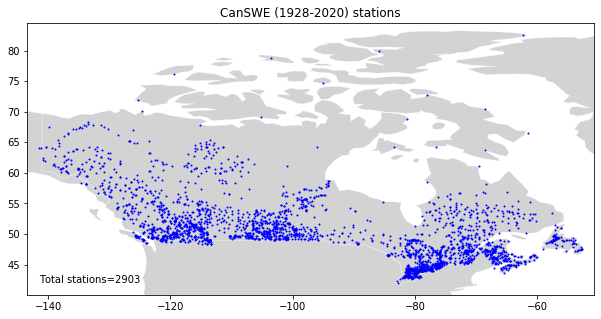

In [9]:
# Plot stations available
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
plt.scatter(SWE_stations_ds.lon, SWE_stations_ds.lat, color='b', s=1)
minx, miny, maxx, maxy = min(SWE_stations_ds.lon),min(SWE_stations_ds.lat),max(SWE_stations_ds.lon),max(SWE_stations_ds.lat)
ax.set_xlim(minx - 2, maxx + 2)
ax.set_ylim(miny - 2, maxy + 2)
plt.text(minx,miny,'Total stations='+str(len(SWE_stations_ds.station_id)))
plt.title('CanSWE (1928-2020) stations');

In [24]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)

,station_id,lon,lat,geometry
0,ALE-05AA805,-114.349998,49.266666,POINT (-114.35000 49.26667)
1,ALE-05AA806,-114.633331,49.816666,POINT (-114.63333 49.81667)
2,ALE-05AD802,-114.050003,49.250000,POINT (-114.05000 49.25000)
3,ALE-05AE804,-113.716667,48.833332,POINT (-113.71667 48.83333)
4,ALE-05AE805,-113.699997,48.766666,POINT (-113.70000 48.76667)
...,...,...,...,...
2898,SK-ECCC051,-104.454643,52.110043,POINT (-104.45464 52.11004)
2899,SK-ECCC053,-107.560806,49.744003,POINT (-107.56081 49.74400)
2900,SK-ECCC052,-106.400002,49.200001,POINT (-106.40000 49.20000)
2901,SK-ECCC054,-107.650002,51.320000,POINT (-107.65000 51.32000)


## Extract SWE observations for test basin
We now extract SWE stations that fall within the test basin (+ optional buffer around the basin).

In [25]:
# Read basin's shapefile
basins_shp = gpd.read_file(shp_path+testbasin_id[0:2]+".shp")
shp_testbasin = basins_shp.loc[basins_shp.Station == testbasin_id]

display(shp_testbasin)

,Station,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry
51,05BB001,BOW RIVER AT BANFF,05BB001_1,2209.593735,340.817572,"POLYGON Z ((-116.45854 51.72693 0.00000, -116...."


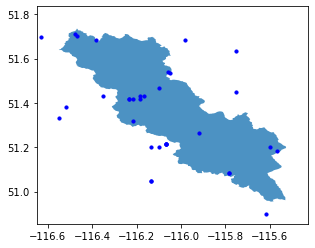

In [13]:
# Plot map of test basin and SWE stations available in the area
stations_basin_map(shp_testbasin, SWE_stations_gdf, flag=flag_buffer_default, buffer_km=buffer_km_default)

In [26]:
# Extract SWE stations within (buffer of) basin and save info to DataFrame
SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, shp_testbasin, testbasin_id, buffer_km=buffer_km_default)[0]

print('There are',str(len(SWE_stations_in_basin.index)),'SWE stations within the test basin.')

display(SWE_stations_in_basin)

There are 17 SWE stations within the test basin.


,station_id,lon,lat,geometry,basin
14,ALE-05BA811,-116.466667,51.700001,POINT (-116.46667 51.70000),05BB001
873,SCD-AL003,-115.566666,51.183334,POINT (-115.56667 51.18333),05BB001
895,SCD-AL055,-115.599998,51.200001,POINT (-115.60000 51.20000),05BB001
905,SCD-AL091,-116.233330,51.416668,POINT (-116.23333 51.41667),05BB001
930,SCD-AL142,-115.916664,51.266666,POINT (-115.91666 51.26667),05BB001
932,SCD-AL148,-116.183334,51.433334,POINT (-116.18333 51.43333),05BB001
2466,ALE-05BA801,-116.183334,51.416668,POINT (-116.18333 51.41667),05BB001
2467,ALE-05BA802,-116.166664,51.433334,POINT (-116.16666 51.43333),05BB001
2468,ALE-05BA806,-116.233330,51.416668,POINT (-116.23333 51.41667),05BB001
2469,ALE-05BA808,-116.216667,51.416668,POINT (-116.21667 51.41667),05BB001


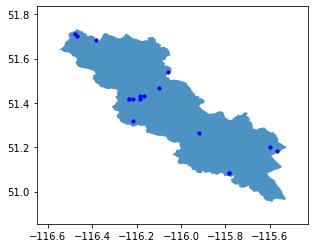

In [16]:
# Plot map of test basin (+ optional buffer) and the extracted SWE stations
stations_basin_map(shp_testbasin, SWE_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

In [75]:
# Sub-select test basin SWE observations from the Canadian dataset
SWE_testbasin_ds = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values)

display(SWE_testbasin_ds)

<xarray.Dataset>
Dimensions:       (station_id: 17, time: 33816)
Coordinates:
    lat           (station_id) float32 51.7 51.183334 ... 51.083332 51.540554
    lon           (station_id) float32 -116.46667 -115.566666 ... -116.05639
    station_name  (station_id) object 'BOW SUMMIT (OLD)' ... 'SKOKI LODGE PILLOW'
  * time          (time) datetime64[ns] 1928-01-01 1928-01-02 ... 2020-07-31
  * station_id    (station_id) object 'ALE-05BA811' ... 'ALE-05CA805P'
Data variables:
    snw           (station_id, time) float32 ...

In [76]:
# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T

# Remove time from dates
SWE_testbasin['date'] = SWE_testbasin.index.normalize()
SWE_testbasin = SWE_testbasin.set_index('date')

# Drop the dates with no data at all across all stations
SWE_testbasin = SWE_testbasin.dropna(axis=0, how='all')

display(SWE_testbasin)

station_id,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,ALE-05BB803P,ALE-05CA805P,SCD-AL003,SCD-AL055,SCD-AL091,SCD-AL142,SCD-AL148
date,,,,,,,,,,,,,,,,,
1937-03-30,97.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938-03-31,208.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-30,NaN,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-31,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-03-28,NaN,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50126,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.01625,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.09906,NaN,NaN,NaN,NaN,NaN,NaN


## Plot test basin SWE observations
We now make a few plots of the SWE stations data within the test basin.

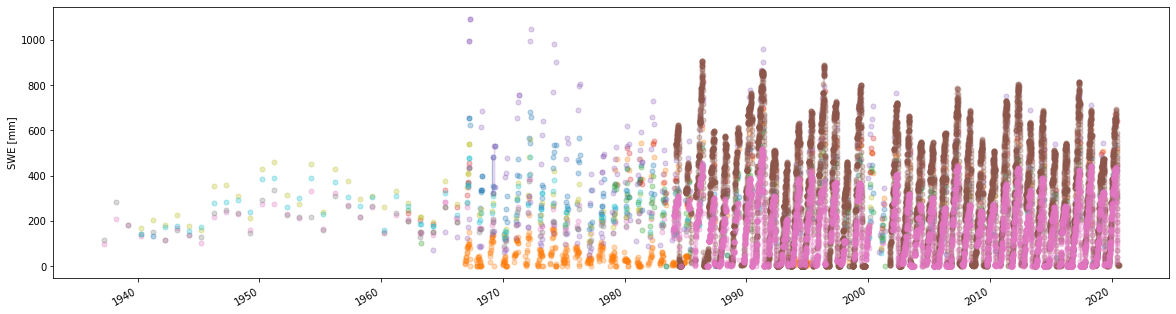

In [17]:
# Plot timeseries of test basin SWE observations
plt.figure(figsize=(20,5))

for s in SWE_testbasin_ds.station_id:
    SWE_testbasin_ds.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=5)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('');

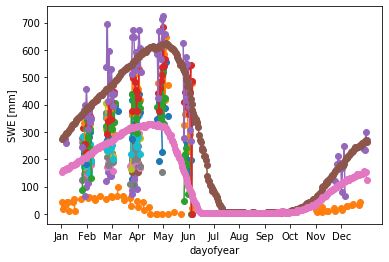

In [18]:
# Plot timeseries of test basin SWE observations climatological means

# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    for s in SWE_testbasin_ds.station_id:
        testbasin_SWE_climatology_means = SWE_testbasin_ds.snw.sel(station_id = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o')
    
    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.ylabel('SWE [mm]');

We can see a striking difference in data availability between the more continuous automatic stations and the discontinuous manual surveys.

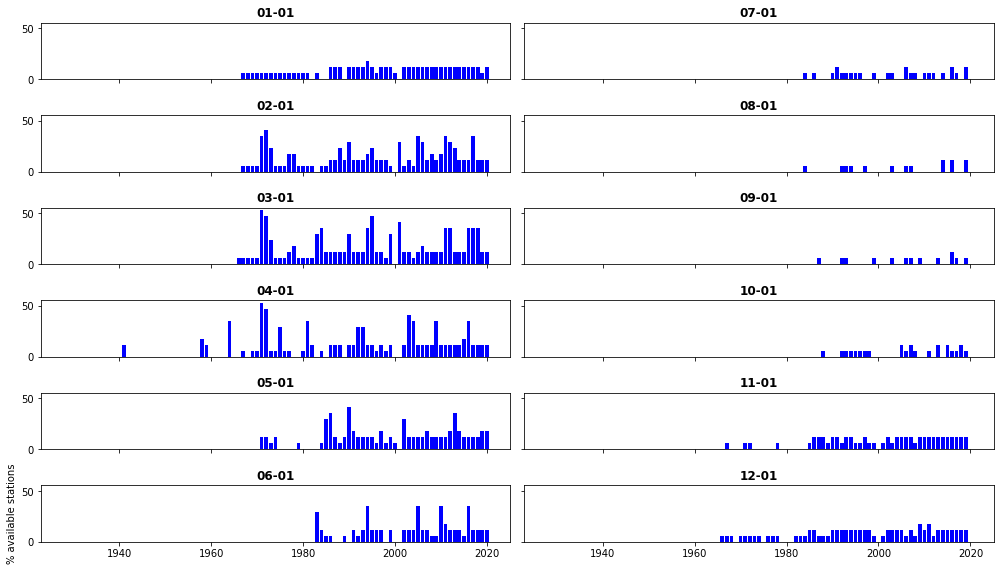

In [39]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month
data_availability_monthly_plots(SWE_stations_in_basin, SWE_testbasin_ds.snw, None, flag=0)

We understand that SWE measurements may not always be taken on the first of the month if they are manual measurements. In order to check how far from the first of each month measurements are taken within the test basin, we plot the SWE observations available around the first of day of each month.

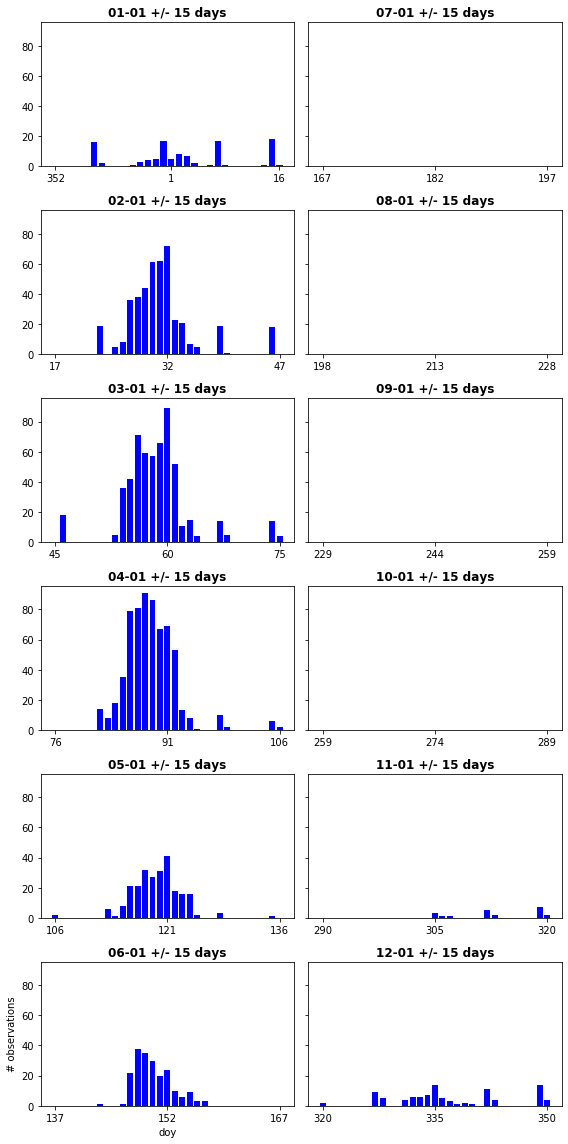

In [41]:
# Plot bar chart of the days with SWE observations around the 1st day of each month

# Initialize plot
fig, axs = plt.subplots(6, 2, sharex=False, sharey=True, figsize=(8,16))
elem = -1
column = 0

# Add day of year (doy) to test basin SWE observations Pandas DataFrame
SWE_testbasin_with_doy = SWE_testbasin.copy()
SWE_testbasin_with_doy['doy'] = SWE_testbasin_with_doy.index.dayofyear

# Remove automatic stations as they distract the analysis
manual_stations = [s for s in SWE_testbasin_with_doy.columns if s[-1] != 'P']
SWE_testbasin_with_doy_manual = SWE_testbasin_with_doy[manual_stations]

# Define the doys of 1st of each month
doys_first_month = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]

# Loop over months
for m in range(1,12+1):

    # controls for plotting on right subplot
    elem += 1
    if elem == 6:
        column += 1
        elem = 0

    # calculate the start & end of the data selection window, with caution around the start & end of the calendar year
    window_start = (doys_first_month[m-1]-15)%366 
    if window_start == 0:
        window_start = 365
    window_end = (doys_first_month[m-1]+15)%366
    if window_end == 0 or window_end == 365:
        window_end = 366

    # select SWE observations within window
    if window_start > window_end:
        data_window = SWE_testbasin_with_doy_manual[(SWE_testbasin_with_doy_manual['doy']>=window_start) | (SWE_testbasin_with_doy_manual['doy'] <= window_end)]
    else:
        data_window = SWE_testbasin_with_doy_manual[(SWE_testbasin_with_doy_manual['doy']>=window_start) & (SWE_testbasin_with_doy_manual['doy'] <= window_end)]

    # drop dates or stations with no data at all
    data_window = data_window.dropna(axis=0, how='all')
    data_window = data_window.dropna(axis=1, how='all')

    # count total number of stations with data on each doy
    stations_cols = [c for c in data_window.columns if 'doy' not in c]
    data_stations_window = data_window[stations_cols]
    data_count_window = data_stations_window.count(axis=1)

    # create xticks to plot the data for each doy
    if window_start > window_end:
        xticks = list(np.arange(window_start,365+1))+list(np.arange(1,window_end+1))
    else:
        xticks = list(np.arange(window_start,window_end+1))
    xticks_plot = np.arange(len(xticks))

    # save the data for the right doy
    data_count_plot = [0]*len(xticks)
    for x in range(len(data_window.index)):
        doy = data_window.iloc[x]['doy']
        if doy == 366:
            doy = 365
        data_count_plot[xticks.index(doy)] += data_count_window.iloc[x]

    # plot data
    axs[elem,column].bar(xticks_plot, data_count_plot, color='b')
    axs[elem,column].set_xticks([xticks_plot[0],xticks_plot[15],xticks_plot[-1]])
    axs[elem,column].set_xticklabels([xticks[0],doys_first_month[m-1],xticks[-1]])

    # add plot labels
    if elem == 5 and column == 0:
        axs[elem,column].set_ylabel('# observations')
        axs[elem,column].set_xlabel('doy')
    axs[elem,column].set_title("{0:0=2d}".format(m)+'-'+"{0:0=2d}".format(1)+' +/- 15 days', fontweight='bold')

plt.tight_layout();

For the Bow at Banff, we can see that most of the manual SWE observations are taken within a +/- 7 day window around the first day of each month during the winter season.

# Precipitation observations

## Read P observations
First, we read the Canadian P observations available.

In [4]:
# Read meteorological stations observations NetCDF
met_stations_ds = xr.open_dataset(met_obs_path)

display(met_stations_ds)

<xarray.Dataset>
Dimensions:    (lle: 3, nchar: 13, nday: 14610, nsf: 3, nstn: 27276)
Dimensions without coordinates: lle, nchar, nday, nsf, nstn
Data variables:
    ID         (nchar, nstn) |S1 ...
    LLE        (lle, nstn) float32 ...
    date       (nday) int32 ...
    sflag      (nsf, nstn) |S1 ...
    prcp       (nstn, nday) float32 ...
    prcp_flag  (nstn, nday) float64 ...
    prcp_kge   (nstn) float32 ...
    tmin       (nstn, nday) float32 ...
    tmin_flag  (nstn, nday) float64 ...
    tmin_kge   (nstn) float32 ...
    tmax       (nstn, nday) float32 ...
    tmax_flag  (nstn, nday) float64 ...
    tmax_kge   (nstn) float32 ...

In [5]:
# Convert meteorological stations DataSet to GeoDataFrame for further analysis
data = {'lon': met_stations_ds.LLE.data[1], 
        'lat': met_stations_ds.LLE.data[0],
        'elev': met_stations_ds.LLE.data[2]} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
met_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(met_stations_gdf)

,lon,lat,elev,geometry
0,-123.279999,48.869999,4.000000,POINT (-123.28000 48.87000)
1,-123.470001,48.599998,38.000000,POINT (-123.47000 48.60000)
2,-123.419998,48.580002,53.299999,POINT (-123.42000 48.58000)
3,-123.389999,48.570000,38.000000,POINT (-123.39000 48.57000)
4,-123.739998,48.939999,75.000000,POINT (-123.74000 48.94000)
...,...,...,...,...
27271,-158.516693,59.049999,26.200001,POINT (-158.51669 59.05000)
27272,-134.644699,56.247200,3.700000,POINT (-134.64470 56.24720)
27273,-156.675293,20.962500,73.199997,POINT (-156.67529 20.96250)
27274,-115.946098,47.508301,1268.000000,POINT (-115.94610 47.50830)


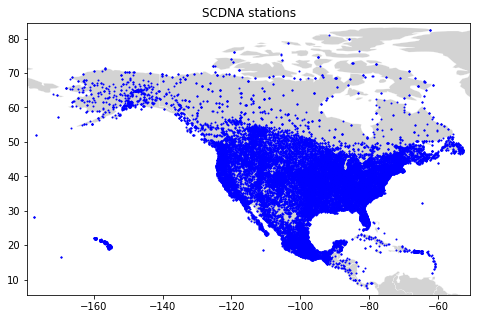

In [6]:
# Plot stations available
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
plt.scatter(met_stations_gdf.lon, met_stations_gdf.lat, color='b', s=1)
minx, miny, maxx, maxy = min(met_stations_gdf.lon),min(met_stations_gdf.lat),max(met_stations_gdf.lon),max(met_stations_gdf.lat)
ax.set_xlim(minx - 2, maxx + 2)
ax.set_ylim(miny - 2, maxy + 2)
plt.title('SCDNA stations');

## Extract meteorological observations for test basin
We now extract meteorological stations that fall within the test basin (+ optional buffer around the basin).

In [83]:
# Extract P stations within (buffer of) basin and save info to DataFrame
met_stations_in_basin = extract_stations_in_basin(met_stations_gdf, shp_testbasin, testbasin_id, buffer_km=buffer_km_default)[0]

print('There are',str(len(met_stations_in_basin.index)),'meteorological stations within the test basin.')

display(met_stations_in_basin)

There are 6 meteorological stations within the test basin.


,lon,lat,elev,geometry,basin
898,-115.550003,51.189999,1396.900024,POINT (-115.55000 51.19000),05BB001
904,-115.919998,51.270000,1524.000000,POINT (-115.92000 51.27000),05BB001
923,-116.220001,51.430000,1524.000000,POINT (-116.22000 51.43000),05BB001
934,-115.779999,51.070000,2186.899902,POINT (-115.78000 51.07000),05BB001
2644,-115.566704,51.183300,1384.000000,POINT (-115.56670 51.18330),05BB001
27083,-115.550003,51.200001,1396.000000,POINT (-115.55000 51.20000),05BB001


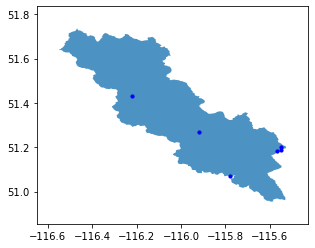

In [84]:
# Plot map of test basin (+ optional buffer) and the extracted meteorological stations
stations_basin_map(shp_testbasin, met_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

In [85]:
# Extract only precipitation observations in the test basin, with at least 1 observation
P_testbasin_da = met_stations_ds.sel(nstn=met_stations_in_basin.index).prcp.dropna(dim='nstn', how='all')

display(P_testbasin_da)

<xarray.DataArray 'prcp' (nstn: 5, nday: 14610)>
array([[ 0.      ,  0.363043,  0.      , ...,  7.1     ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 20.466087,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 14.470592,  0.62419 ,  0.53611 ],
       [ 0.      ,  0.      ,  0.      , ..., 28.7     ,  0.3     ,  0.3     ],
       [ 0.      ,  0.      ,  0.      , ..., 28.702   ,  0.254   ,  0.254   ]],
      dtype=float32)
Dimensions without coordinates: nstn, nday
Attributes:
    description:  SCD precipitation (mm/day)

In [88]:
# Convert test basin SWE data DataArray to Pandas DataFrame for further analysis
P_testbasin = P_testbasin_da.to_dataframe().unstack().T
P_testbasin['date'] = pd.to_datetime(met_stations_ds.sel(nstn=met_stations_in_basin.index).date.data, format='%Y%m%d')
P_testbasin = P_testbasin.set_index('date')
P_testbasin.columns = ['precip_' + str(col) for col in P_testbasin.columns]

display(P_testbasin)

,precip_0,precip_1,precip_2,precip_3,precip_4
date,,,,,
1979-01-01,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-02,0.363043,0.000000,0.000000,0.000000,0.000
1979-01-03,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-04,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-05,0.000000,0.000000,0.000000,0.000000,0.000
...,...,...,...,...,...
2018-12-27,0.000000,0.000000,0.000000,0.000000,0.000
2018-12-28,21.799999,0.000000,0.000000,0.000000,0.000
2018-12-29,7.100000,20.466087,14.470592,28.700001,28.702


## Process test basin precipitation observations
We finally process the test basin precipitation observations for use by the gap filling methodology by calculating station cumulative precipitation outputs for all snow seasons.

In [89]:
# Calculate the water year cumulative precipitation for all stations within the test basin
    
# Add water years as an extra column to the P observations Pandas DataFrame
year = []
for i in P_testbasin.index:
    if (i.month == month_start_water_year_default and i.day >= day_start_water_year_default) or (i.month > month_start_water_year_default):
        year.append(i.year + 1)
    else:
        year.append(i.year)
P_testbasin['water_year'] = year

# Calculate the cumulative precipitation
elem = -1
for y in list(set(P_testbasin['water_year'])):
    elem += 1
    P_testbasin_water_year = P_testbasin[P_testbasin['water_year']==y]
    P_testbasin_water_year_cumul = P_testbasin_water_year.cumsum().drop(['water_year'], axis=1)
    if elem == 0:
        P_cumul_testbasin = P_testbasin_water_year_cumul
    else:
        P_cumul_testbasin = pd.concat([P_cumul_testbasin,P_testbasin_water_year_cumul])

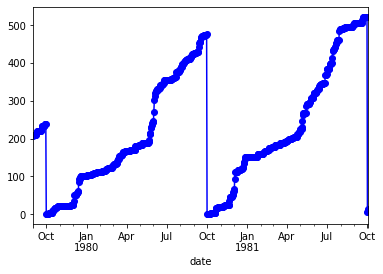

In [90]:
# Visually check that this is right for a time range
P_cumul_testbasin['precip_0']['1979-09-01':'1981-10-02'].plot(marker='o', color='b');

# SWE pre-processing

In [91]:
# Combine SWE & P test basin observations in a single Pandas DataFrame
SWE_P_testbasin = SWE_testbasin.merge(P_cumul_testbasin, left_index=True, right_index=True, how='outer')

display(SWE_P_testbasin)

,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,...,SCD-AL003,SCD-AL055,SCD-AL091,SCD-AL142,SCD-AL148,precip_0,precip_1,precip_2,precip_3,precip_4
date,,,,,,,,,,,,,,,,,,,,,
1937-03-30,97.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938-03-31,208.0,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-30,NaN,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939-03-31,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-03-28,NaN,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SWE gap filling with quantile mapping
We run a quantile mapping method to fill up gaps in the SWE observations using neighbouring SWE or P stations' observations. This is done by first identifying for each target station (i.e., station with a gap to fill) and date, an optimal donor station (i.e., a SWE or P station in the same basin with the best correlation to the target station, where the correlation > minimum allowed correlation value specified in the user-specified variables above). Once an optimal donor station has been selected for a target station & given date, we fill in the gap using quantile mapping.

In [56]:
# Perform gap filling for the original dataset (no artificial gaps, flag=0)
# Note: this may take quite a while to run, depending on the number of gaps to fill
SWE_P_gapfill_testbasin, flags_gapfill_testbasin, donor_stationids_gapfill_testbasin = qm_gap_filling(SWE_P_testbasin, None, window_days=window_days_default, min_obs_overlap=min_obs_overlap_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, flag=0)

In [58]:
# Save gap filled dataset and metadata to single dataset
SWE_P_gapfill_testbasin_da = xr.DataArray(data=SWE_P_gapfill_testbasin.values, coords=dict(time=SWE_P_gapfill_testbasin.index.values, station_id=SWE_P_gapfill_testbasin.columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
flags_gapfill_testbasin_da = xr.DataArray(data=flags_gapfill_testbasin.values, coords=dict(time=flags_gapfill_testbasin.index.values, station_id=flags_gapfill_testbasin.columns.values), dims=['time','station_id'], name='flag', attrs={'description':'observations = 0; estimates = 1'})
donor_stationids_gapfill_testbasin_da = xr.DataArray(data=donor_stationids_gapfill_testbasin.values, coords=dict(time=donor_stationids_gapfill_testbasin.index.values, station_id=donor_stationids_gapfill_testbasin.columns.values), dims=['time','station_id'], name='donor_stations', attrs={'description':'station_id of donor stations used for gap filling'})
SWE_P_gapfill_testbasin_ds = xr.merge([SWE_P_gapfill_testbasin_da, flags_gapfill_testbasin_da, donor_stationids_gapfill_testbasin_da])

display(SWE_P_gapfill_testbasin_ds)

<xarray.Dataset>
Dimensions:         (station_id: 17, time: 15583)
Coordinates:
  * time            (time) datetime64[ns] 1937-03-30 1938-03-31 ... 2020-07-30
  * station_id      (station_id) object 'ALE-05BA801' ... 'SCD-AL148'
Data variables:
    SWE             (time, station_id) float32 97.0 117.0 163.98 ... nan nan nan
    flag            (time, station_id) float64 0.0 0.0 1.0 1.0 ... 0.0 0.0 0.0
    donor_stations  (time, station_id) object nan nan 'ALE-05BA802' ... nan nan

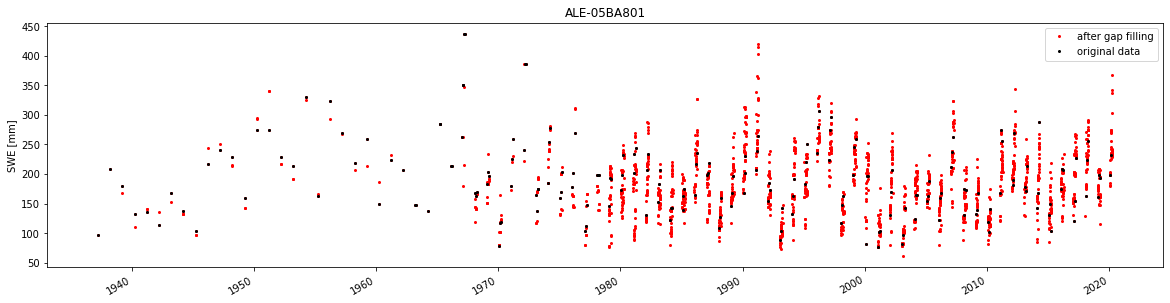

In [36]:
# Plot the first SWE station in the dataset to visually check quantile mapping results
plt.figure(figsize=(20,5))
SWE_P_gapfill_testbasin_ds.SWE.isel(station_id=0).plot(color='r', marker='o', ms=2, label='after gap filling', lw=0)
SWE_P_testbasin.iloc[:,0].plot(color='k', marker='o', ms=2, label='original data', lw=0)
plt.title(SWE_P_testbasin.iloc[:,0].name)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

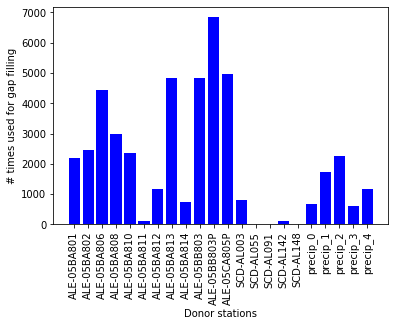

In [78]:
# Plot bar chart of the number of times each donor station was used for gap filling
count = []

for s in SWE_P_testbasin.columns.values:
    count_s = SWE_P_gapfill_testbasin_ds.donor_stations.where(SWE_P_gapfill_testbasin_ds.donor_stations==s).count().data
    count.append(count_s)
    
plt.bar(SWE_P_testbasin.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for gap filling');

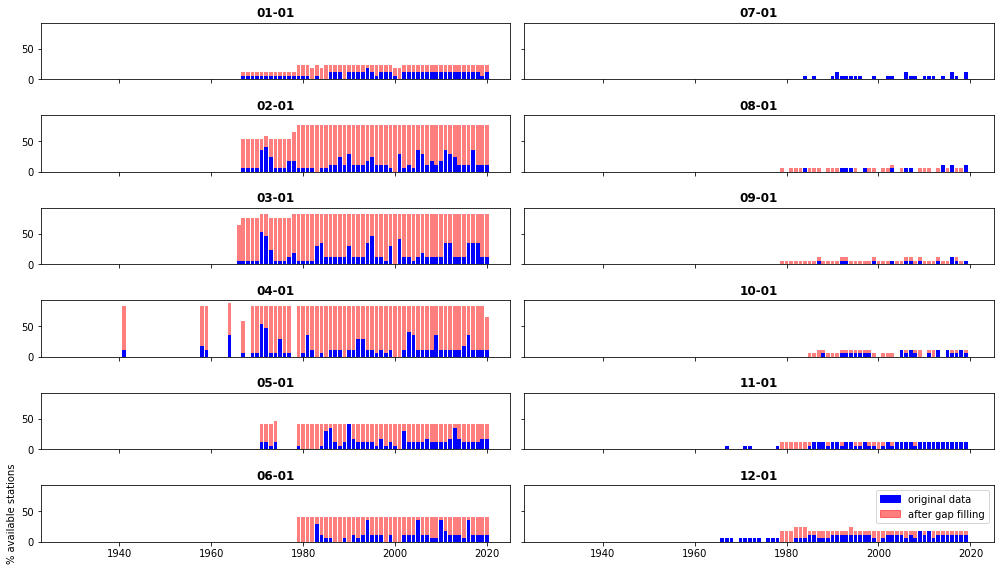

In [92]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1)
data_availability_monthly_plots(SWE_stations_in_basin, SWE_testbasin_ds.snw, SWE_P_gapfill_testbasin_ds.SWE, flag=1)

### Artificial gap filling evaluation

Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 8
i

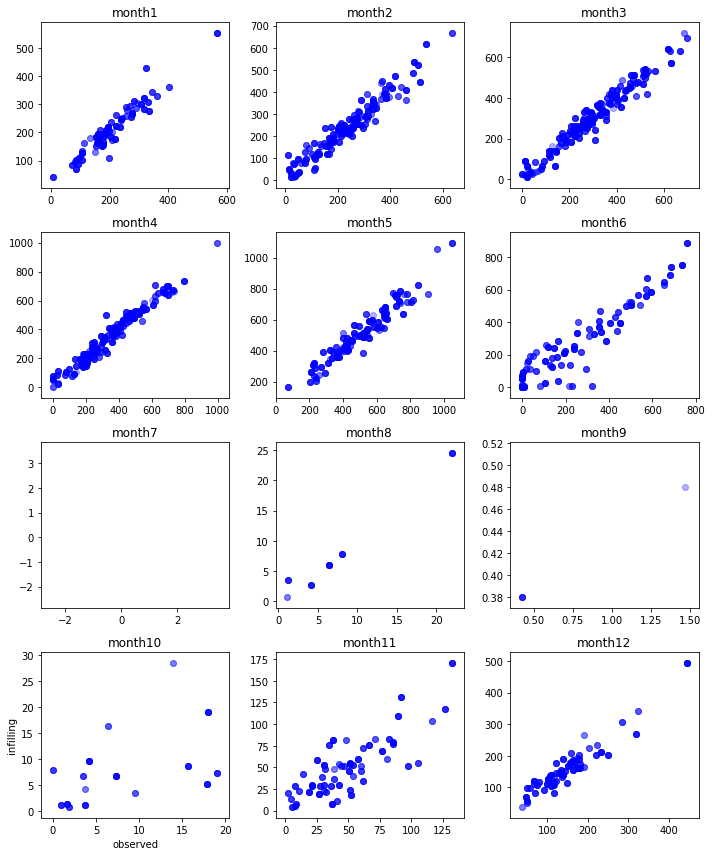

In [28]:
# Perform artificial gap filling evaluation and plot the results (flag=1)
evaluation_artificial_gapfill_testbasin = artificial_gap_filling(SWE_P_testbasin, iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=window_days_default, min_obs_overlap=min_obs_overlap_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=1)

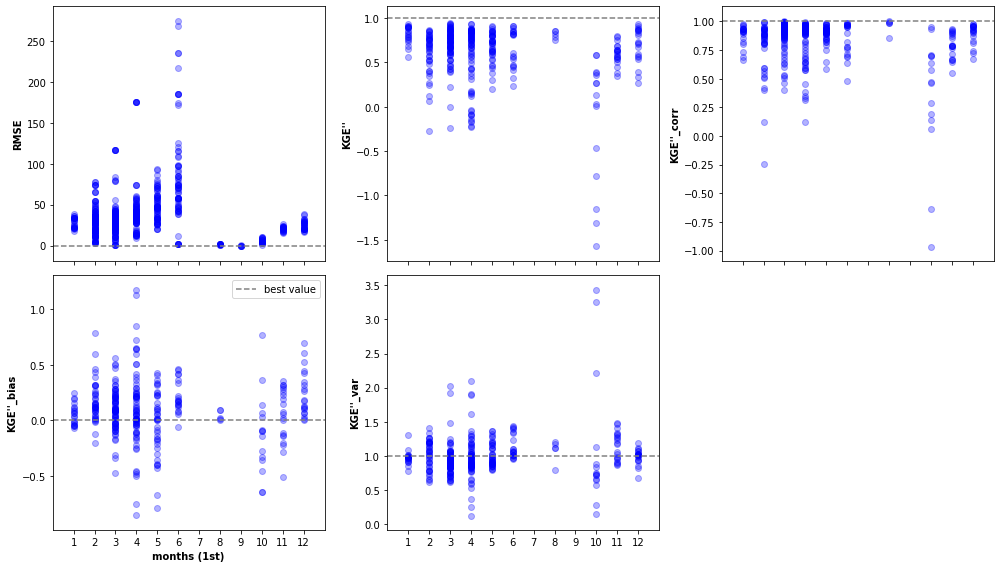

In [45]:
# Plot artificial gap filling evaluation results
plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin)

For the Bow at Banff, we can see some low scores which are caused by specific stations. This can sometimes happens for certain cases and stations with very few gaps to fill. If various donor stations are used to fill out these gaps then there are some inconsistencies across infilling values and the overall correlation between the infilling values and the observations is poor.

## Principal Component Analysis (PCA)
We run a [principal component analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to find components that explain the variance in the gap filled stations observations dataset. PCA is used to extract a small number of non-correlated factors which could contain most of the information in the original dataset and improve the predictions. PCA is also helpful in separating signal from noise in the original dataset.

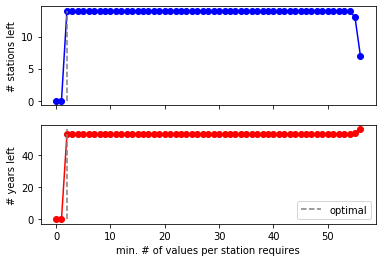

In [62]:
# Extract optimal # stations & years of data for a specific month as an example to see how it works & plot it (flag=1)
month_SWE_P_gapfill_testbasin = extract_monthly_data(SWE_P_gapfill_testbasin, month=4, flag=1)

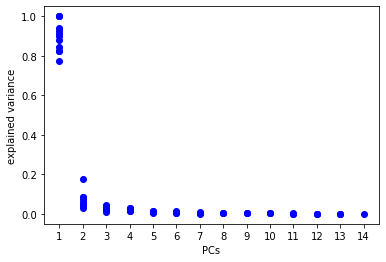

In [17]:
# Run PCA and plot the PCs explained variance (flag=1)
PCs_testbasin, loadings_testbasin = principal_component_analysis(SWE_P_gapfill_testbasin, flag=1)

For the Bow at Banff, this plot show that in general the 1st PC contains most of the signal. Let's see how much of the stations' signal is correlated to these PCs (plots below).

### Plot test basin PCA loadings (correlation between stations & PCs data)

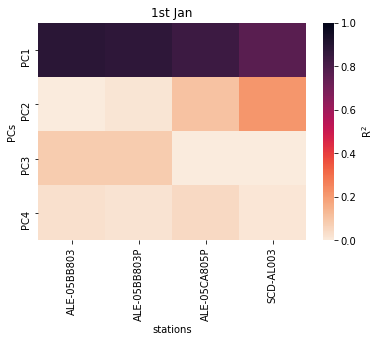

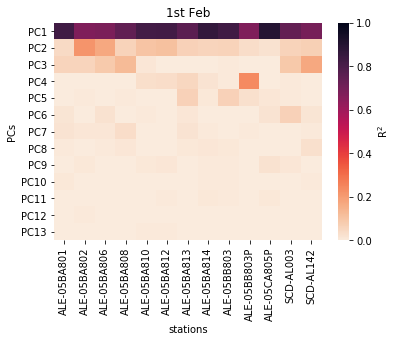

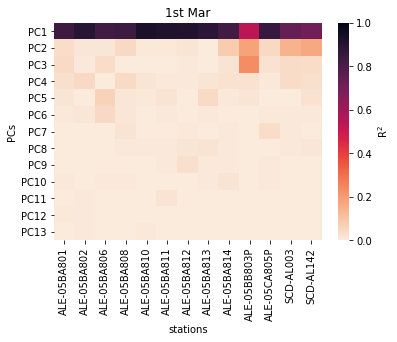

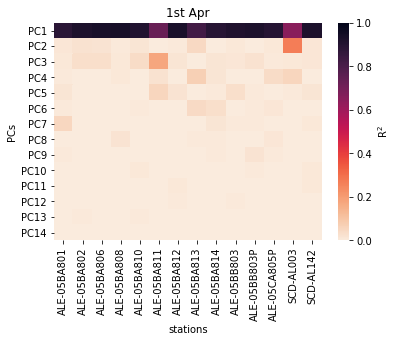

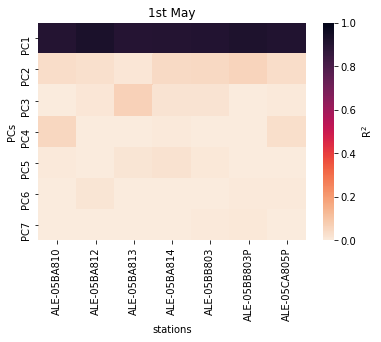

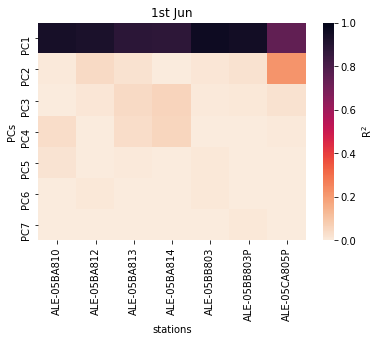

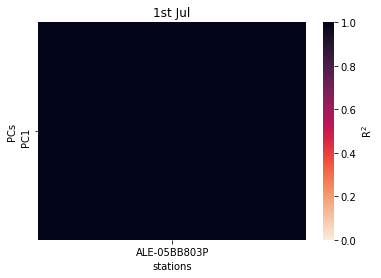

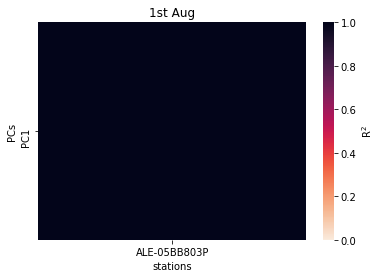

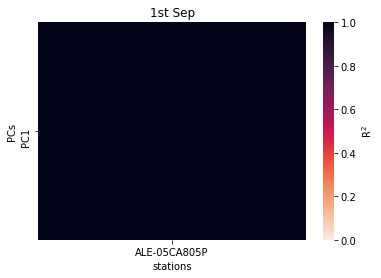

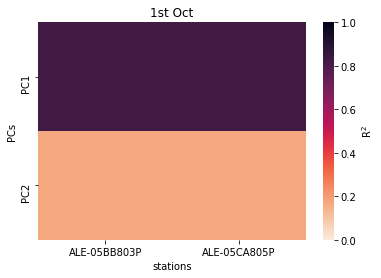

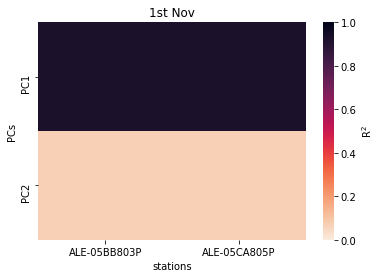

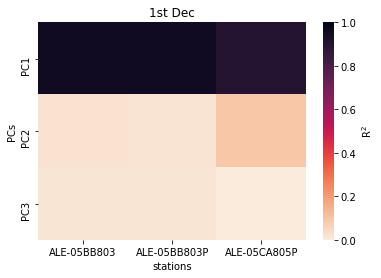

In [85]:
# Matrix plots of loadings per month to see correlations in time
for m in range(1,12+1):
    
    month_name = datetime.datetime.strptime(str(m), "%m").strftime("%b")
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(loadings_testbasin[m], annot=False, cmap=cmap, cbar_kws={'label': 'R$^2$'}, vmin=0, vmax=1)
    ax.set(xlabel="stations", ylabel = "PCs")
    ax.set_title('1st '+month_name);

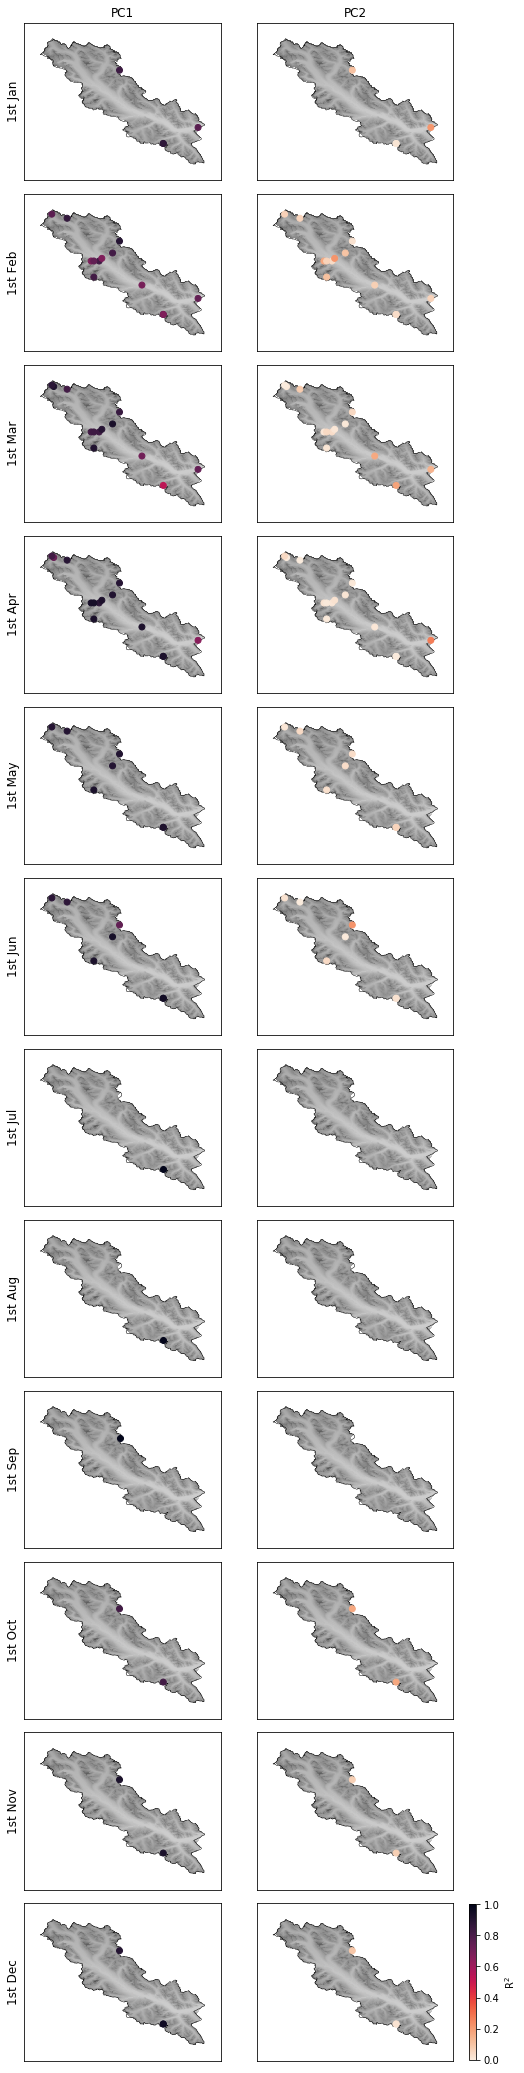

In [72]:
# Maps of loadings (for the 2 first PC1 & PC2) per month to see correlations in time & space

# Initialize figure
fig, ax = plt.subplots(12,2, figsize=[10,30])

# Load DEM
src = rasterio.open(DEM_testbasin)

# Loop over months
for m in range(1,12+1):
            
    # extract geospatial information for stations to plot
    SWE_stations_extract = SWE_stations_in_basin[SWE_stations_in_basin.station_id.isin(loadings_testbasin[m].columns)]
    SWE_stations_extract = SWE_stations_extract.set_index('station_id')
    
    # month name to string
    month_name = datetime.datetime.strptime(str(m), "%m").strftime("%b")
    
    # add basin contour & elevation shading to map
    shp_testbasin.plot(ax=ax[m-1,0], edgecolor='k', facecolor='none', lw=.5)
    shp_testbasin.plot(ax=ax[m-1,1], edgecolor='k', facecolor='none', lw=.5)
    rasterio.plot.show((src, 1), cmap='Greys', vmin=0, ax=ax[m-1,0], alpha=.7)
    rasterio.plot.show((src, 1), cmap='Greys', vmin=0, ax=ax[m-1,1], alpha=.7)
    
    # remove frame ticks
    ax[m-1,0].set_xticks([]) 
    ax[m-1,0].set_yticks([]) 
    ax[m-1,1].set_xticks([]) 
    ax[m-1,1].set_yticks([]) 
    
    # calculate map bounds
    minx, miny, maxx, maxy = shp_testbasin.geometry.total_bounds
    ax[m-1,0].set_xlim(minx - .1, maxx + .1)
    ax[m-1,0].set_ylim(miny - .1, maxy + .1)
    ax[m-1,1].set_xlim(minx - .1, maxx + .1)
    ax[m-1,1].set_ylim(miny - .1, maxy + .1)
    
    # add month label
    ax[m-1,0].set_ylabel('1st '+month_name, fontsize=12)
    
    # extract & plot data for PC1 if available
    if 'PC1' in loadings_testbasin[m].index:
        data_for_map = SWE_stations_extract.merge(loadings_testbasin[m].loc['PC1'], left_index=True, right_index=True, how='outer')
        sc = ax[m-1,0].scatter(data_for_map.lon.values, data_for_map.lat.values, c=data_for_map.PC1.values, cmap='rocket_r', vmin=0, vmax=1)
          
    # extract & plot data for PC2 if available
    if 'PC2' in loadings_testbasin[m].index:
        data_for_map = data_for_map.merge(loadings_testbasin[m].loc['PC2'], left_index=True, right_index=True, how='outer')
        sc = ax[m-1,1].scatter(data_for_map.lon.values, data_for_map.lat.values, c=data_for_map.PC2.values, cmap='rocket_r', vmin=0, vmax=1)
         
    # add PC labels   
    if m == 1:
        ax[m-1,0].set_title('PC1')
        ax[m-1,1].set_title('PC2')  

# Adjust subplots & add colorbar
plt.tight_layout()
fig.subplots_adjust(top=.95, wspace=-.5)
cbar_ax = fig.add_axes([.82,.007,.01,.072])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('R$^2$');

We can now see what some of the spatial patterns are in the signal picked up by PC1 & PC2. For the Bow at Banff:
- For 1st Feb, it's interesting to see that higher correlations with PC1 are situated at high elevations vs low elevations/along the main river channel for PC2.
- For 1st March, PC1 seems to be better correlated with stations upstream of the basin, while PC2 is more correlated to stations downstream.

# Store data
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [93]:
# Store
%store SWE_P_gapfill_testbasin
%store SWE_P_gapfill_testbasin_ds
%store PCs_testbasin

Stored 'SWE_P_gapfill_testbasin' (DataFrame)
Stored 'SWE_P_gapfill_testbasin_ds' (Dataset)
Stored 'PCs_testbasin' (DataFrame)


In [15]:
# Read
%store -r SWE_P_gapfill_testbasin
%store -r SWE_P_gapfill_testbasin_ds
%store -r PCs_testbasin

# Sensitivity tests
Below, we test the sensitivity of the results to the window size.

In [110]:
# Run gap filling for increasing window sizes

# Initialize dictionary to save results
SWE_P_gapfill_testbasin_sensitivity_dict = {}

# Loop over window sizes (in days)
for w in range(7+1):
    
    print('Running gap filling for window length: +/-', w, 'day(s)')
    
    # perform gap filling for the original dataset (no artificial gaps, flag=0)
    SWE_P_gapfill_testbasin_sensitivity_dict[w] = qm_gap_filling(SWE_P_testbasin, None, window_days=w, min_obs_overlap=min_obs_overlap_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, flag=0)[0]

Running gap filling for window length: +/- 0 day(s)
Running gap filling for window length: +/- 1 day(s)
Running gap filling for window length: +/- 2 day(s)
Running gap filling for window length: +/- 3 day(s)
Running gap filling for window length: +/- 4 day(s)
Running gap filling for window length: +/- 5 day(s)
Running gap filling for window length: +/- 6 day(s)
Running gap filling for window length: +/- 7 day(s)


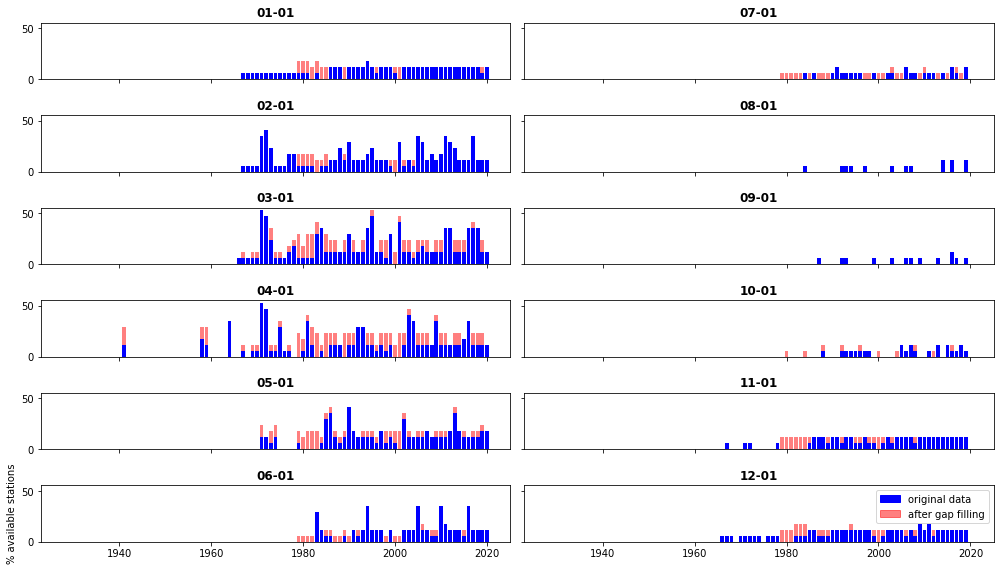

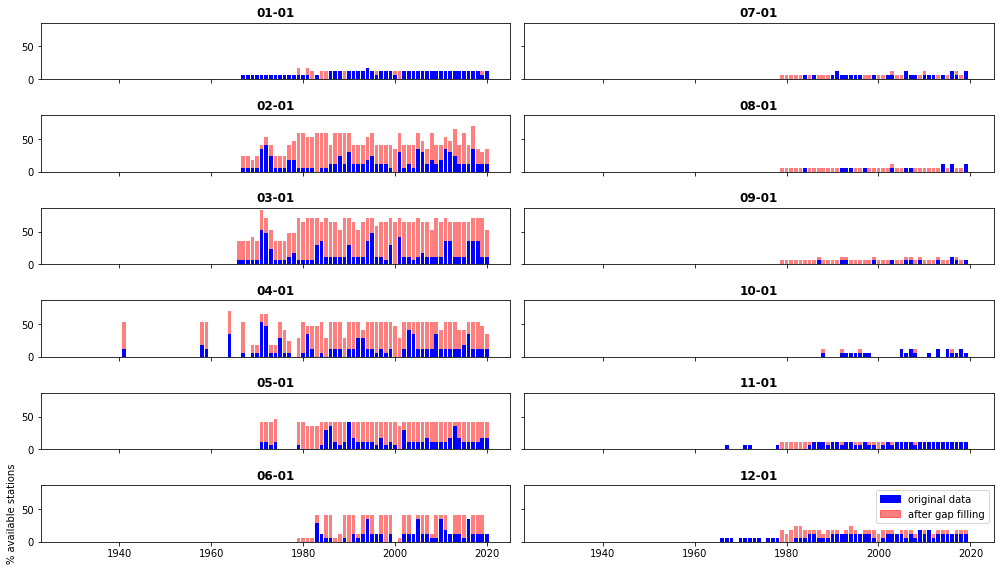

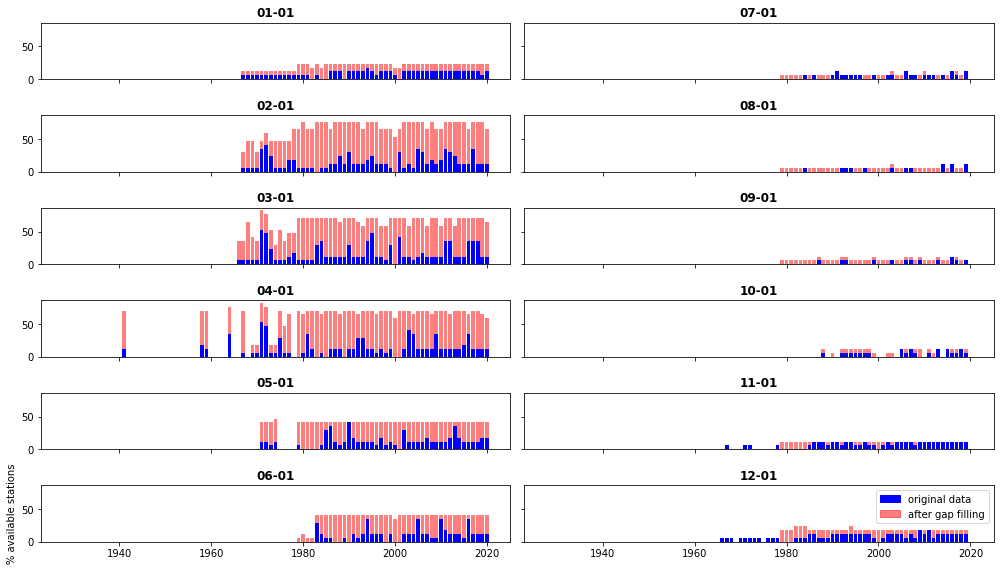

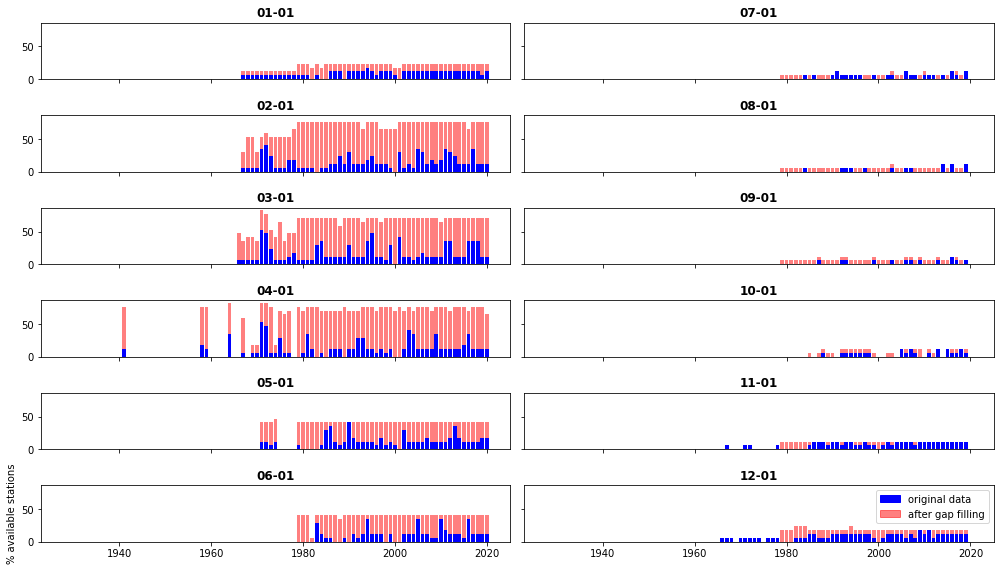

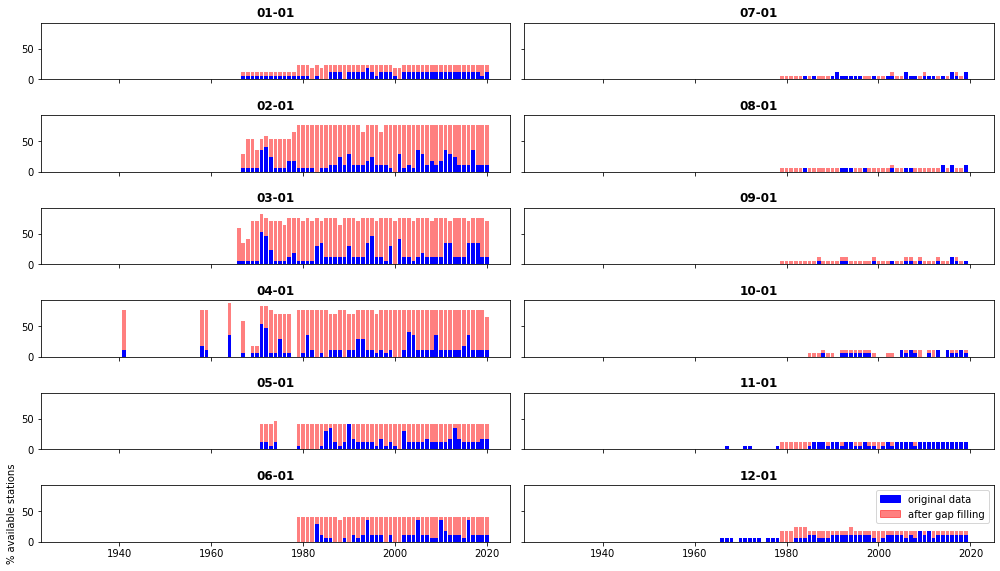

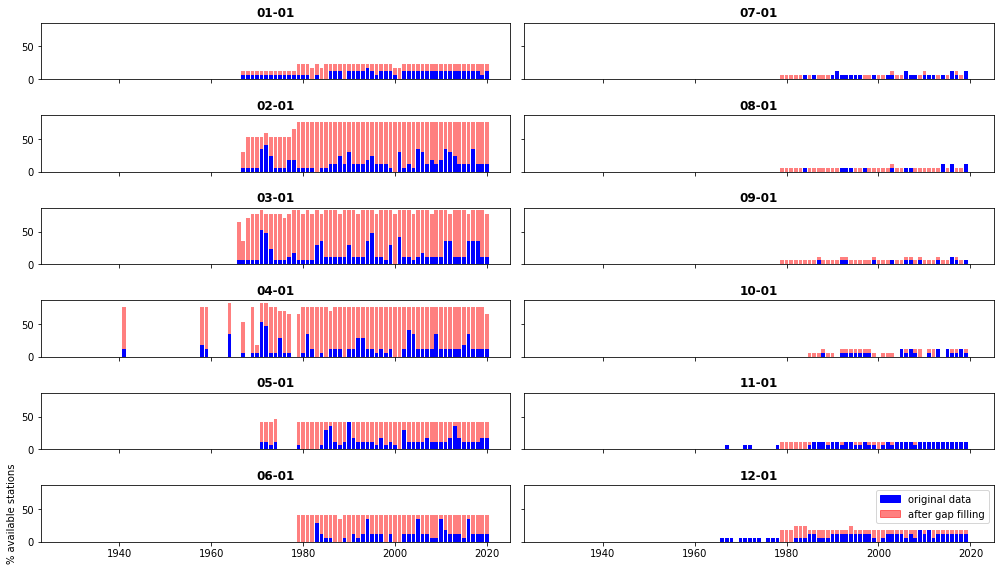

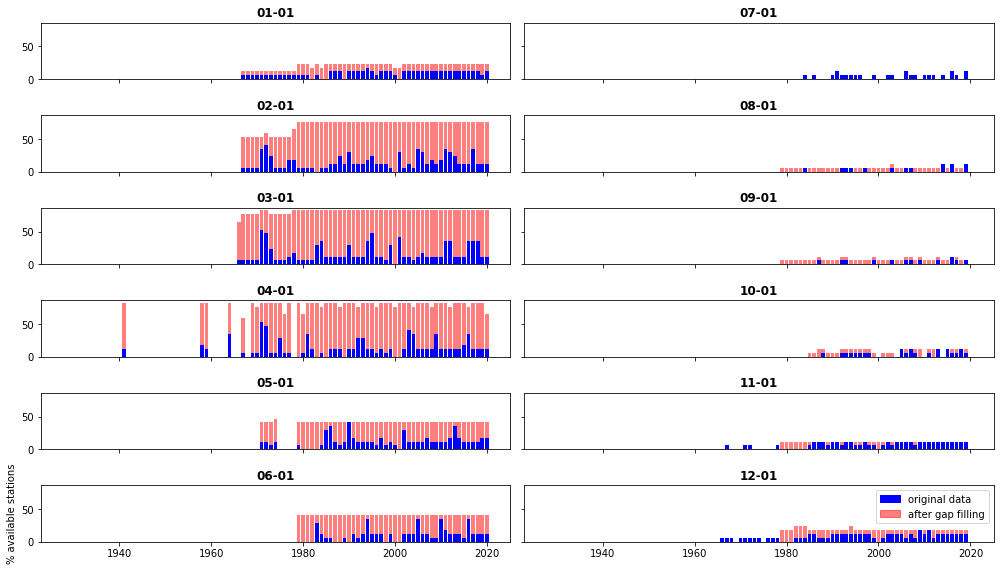

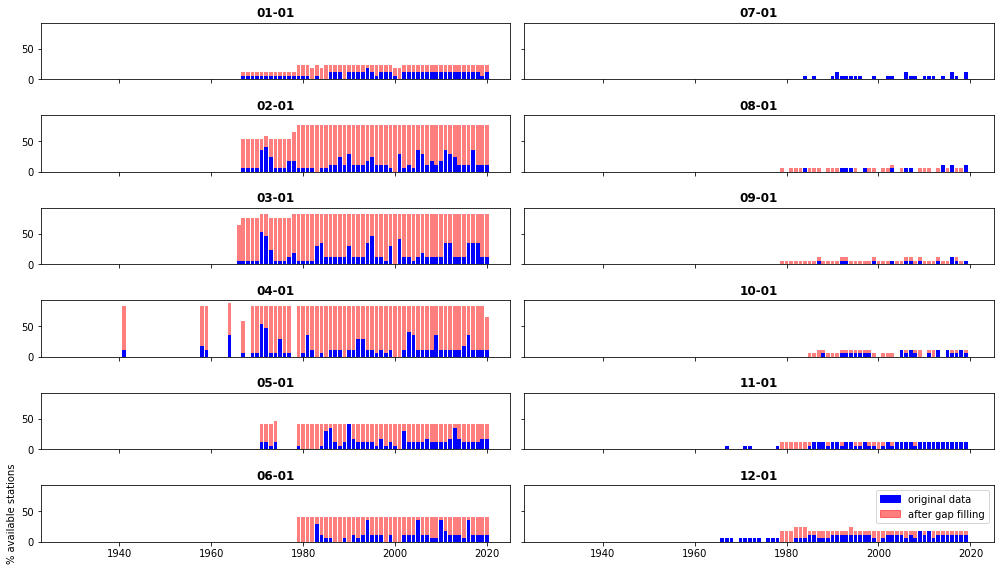

In [111]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1) for increasing window sizes

# Loop over window sizes (in days)
for w in range(7+1):
    
    # convert Panfas DataFrame to Xarray DataArray for plotting
    sensitivity_da = xr.DataArray(data=SWE_P_gapfill_testbasin_sensitivity_dict[w].values, coords=dict(time=SWE_P_gapfill_testbasin_sensitivity_dict[w].index.values, station_id=SWE_P_gapfill_testbasin_sensitivity_dict[w].columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
    
    # plot timeseries
    data_availability_monthly_plots(SWE_stations_in_basin, SWE_testbasin_ds.snw, sensitivity_da, flag=1)

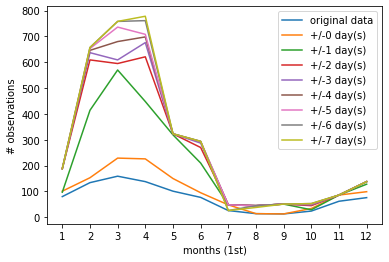

In [112]:
# Plot timeseries of the # of observations in the test basin on the first day of each month, for the original data & after gap filling for increasing window sizes

# Plot for original data
# Initialize list to save results
datafirstmonthcount = [0]*12
# Loop over months
for m in range(1,12+1):
    datafirstmonth = SWE_testbasin[(SWE_testbasin.index.month == m) & (SWE_testbasin.index.day == 1)]
    datafirstmonthcount[m-1] = datafirstmonth.count(axis=1).sum()
plt.plot(np.arange(1,12+1), datafirstmonthcount, label='original data')

# Plot for gap filled data
# Loop over window sizes (in days)
for w in range(7+1):
    # initialize list to save results
    datafirstmonthcount = [0]*12
    # loop over months
    for m in range(1,12+1):
        datafirstmonth = SWE_P_gapfill_testbasin_sensitivity_dict[w][(SWE_P_gapfill_testbasin_sensitivity_dict[w].index.month == m) & (SWE_P_gapfill_testbasin_sensitivity_dict[w].index.day == 1)]
        datafirstmonthcount[m-1] = datafirstmonth.count(axis=1).sum()
    plt.plot(np.arange(1,12+1), datafirstmonthcount, label='+/-'+str(w)+' day(s)')

# Add labels to plot
plt.xticks(np.arange(1,12+1))
plt.legend()
plt.xlabel('months (1st)')
plt.ylabel('# observations');

Running artificial gap filling for window length: +/- 0 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 1 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 2 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 3 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 4 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 5 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 6 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


Running artificial gap filling for window length: +/- 7 day(s)
Working on month 1
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 2
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 3
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 4
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 5
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 6
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
Working on month 7
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iterat

/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


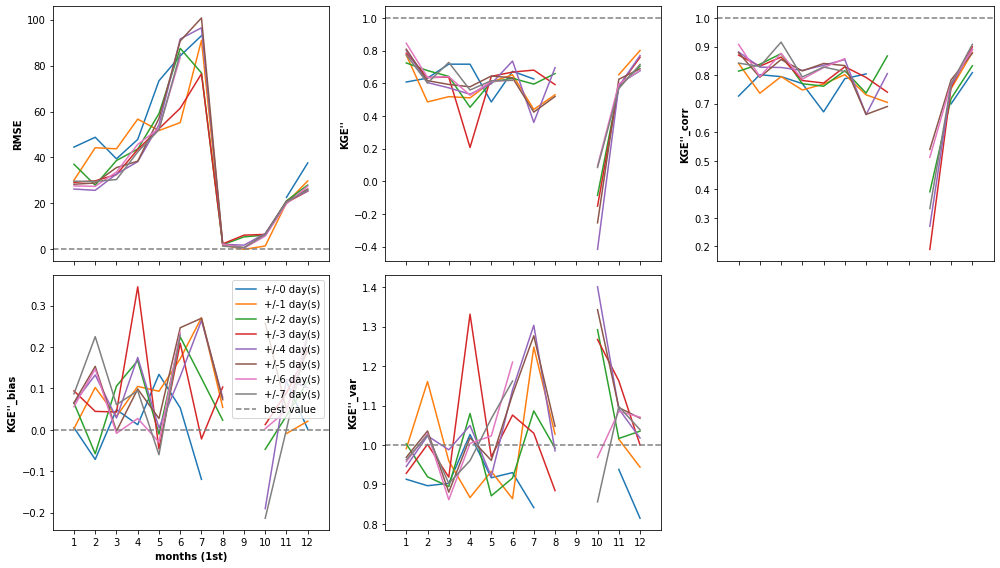

In [113]:
# Plot artificial gap filling evaluation results, for increasing window sizes

# Initialize figure
ncols = 3
fig, axs = plt.subplots(2, ncols, sharex=True, sharey=False, figsize=(14,8))

# Define metrics optimal values
metrics_optimal_values = {'RMSE':0, "KGE''":1, "KGE''_corr":1, "KGE''_bias":0, "KGE''_var":1}

for w in range(7+1):
    
    # controls for figure
    elem = -1
    row = 0

    print('Running artificial gap filling for window length: +/-', w, 'day(s)')
    
    # perform artificial gap filling evaluation and plot the results (flag=1)
    evaluation_artificial_gapfill_testbasin_sensitivity = artificial_gap_filling(SWE_P_testbasin, iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=w, min_obs_overlap=min_obs_overlap_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=0)
        
    metrics = list(evaluation_artificial_gapfill_testbasin_sensitivity.keys())
        
    # loop over metrics to plot
    for m in metrics:

        # controls for plotting on right subplot
        elem += 1
        if elem == ncols:
            row += 1
            elem = 0

        # plot
        average = np.nanmean(evaluation_artificial_gapfill_testbasin_sensitivity[m], axis=(1,2))
        axs[row,elem].plot(np.arange(1,12+1), average, label='+/-'+str(w)+' day(s)')

# controls for figure
elem = -1
row = 0

# loop over metrics to plot
for m in metrics:
 
    # controls for plotting on right subplot
    elem += 1
    if elem == ncols:
        row += 1
        elem = 0

    axs[row,elem].plot(np.arange(0,13+1), [metrics_optimal_values[m]]*14, color='grey', ls='--', label='best value')
    axs[row,elem].set_xlim([0, 13])

    # add labels
    axs[row,elem].set_xticks(np.arange(1,12+1))
    axs[row,elem].set_ylabel(m, fontweight='bold')

axs[1,0].legend()
axs[1,0].set_xlabel('months (1st)', fontweight='bold')
fig.delaxes(axs[1][2])
plt.tight_layout();